In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


# Import scripts

In [4]:
path_scripts = '/Users/simjoo/Projects/10X_PDAC_Lgr5/scripts/v3/'

In [5]:
import sys
sys.path.append(path_scripts)

In [6]:
from ipyparallel import Client
import csv
import os
import pickle
import scipy.io
import scanpy as sc
import anndata
import bbknn
import statsmodels.api as sm
import gseapy as gp
import phenograph as pg
import ternary

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/numba/core/cpu.py:77: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ModuleNotFoundError(No module named 'numba.targets')'.
  numba.core.entrypoints.init_all()


In [7]:
%R library(Seurat)
%R library(SingleCellExperiment)
%R library(scran)
%R library(DropletUtils)
%R library(DESeq2)

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted

array(['DESeq2', 'DropletUtils', 'scran', 'SingleCellExperiment',
       'SummarizedExperiment', 'DelayedArray', 'BiocParallel',
       'matrixStats', 'Biobase', 'GenomicRanges', 'GenomeInfoDb',
       'IRanges', 'S4Vectors', 'BiocGenerics', 'parallel', 'stats4',
       'Seurat', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U20')

In [8]:
from TenX_PDAC_misc_scripts_v1_0 import *
from TenX_PDAC_plot_v1_0 import *
from TenX_PDAC_mann_whitney_u_v1_0 import *

In [9]:
#exp_id = create_ID()

In [10]:
exp_id = '202110251102'
path_input = '/Users/simjoo/Projects/10X_PDAC_Lgr5/data_input/'
path_output = '/Users/simjoo/Projects/10X_PDAC_Lgr5/data_output/v3/'
path_figures = '/Users/simjoo/Projects/10X_PDAC_Lgr5/figures/v3/'

In [11]:
cmap_tab20 = {str(c) : mpl.colors.rgb2hex(plt.cm.tab20(c/20)) for c in range(20)}
cmap_tumor = {'autochthonous':'#d95f02', 'fragment_transplant':'#1b9e77', 'sorted_transplant':'#7570b3',
              '2D':'#e7298a','3D_2%':'#66a61e','3D_Tuv':'#e6ab02',}
cmap_treatment = {'3d_TAM':'#addd8e','10d_Veh':'#31a354','20d_TAM':'#006837',
                  '10d_LGK':'#fd8d3c','20d_LGK':'#bd0026','10d_Gem':'#2c7fb8'}
cmap_lineage_tracing = {'tdTomato': '#d95f02', 'Negative': 'silver', 'tdTomato-GFP': '#e6ab02', 'GFP': '#66a61e'}
cmap_cl_tumor = {'Luminal cells':'#7570b3',
               'Basal cells':'#1b9e77',
               'Mesenchymal cells':'#d95f02'}

# Initialize engines

In [12]:
c = Client()

In [13]:
dview = c[:]

In [14]:
dview.execute('import sys')
dview.execute('sys.path.append("/Users/simjoo/Projects/10X_PDAC_Lgr5/scripts/v3/")')
dview.execute('from TenX_PDAC_misc_scripts_v1_0 import *')
dview.execute('from TenX_PDAC_plot_v1_0 import *')
dview.execute('from TenX_PDAC_mann_whitney_u_v1_0 import *')

<AsyncResult: execute>

# Analysis of lineage traced cells

In [15]:
X = sc.read_h5ad('%s/%s_X_PDAC_Lgr5_pp.h5' % (path_output, exp_id))

In [16]:
X.X = X.layers['norm_log2']

In [17]:
Xs = sc.read_h5ad('%s/%s_Xs_PDAC_Lgr5_tumor_fit_on_aut.h5' % (path_output, exp_id))

## Fix misassignment of treatment

In [18]:
Xs.obs['treatment'][Xs.obs['batch']=='OG-1331_Day3_100621'] = '3d_TAM'
Xs.obs['treatment'] = Xs.obs['treatment'].cat.add_categories('10d_TAM')
Xs.obs['treatment'][Xs.obs['batch']=='AS-1258_D10Tam_Autoch_plus_mTmGFrag_NSGFrag'] = '10d_TAM'

## Select fragment transplants

In [19]:
c_sel = Xs.obs[Xs.obs['tumor'].isin(['NSG_fragment'])].index

In [20]:
Xs = Xs[c_sel]

## Select lineage traced samples

In [21]:
c_sel = Xs.obs['treatment'][Xs.obs['treatment'].isin(['3d_TAM','10d_Veh','10d_TAM','20d_TAM'])].index

In [22]:
len(c_sel)

33440

In [23]:
Xs = Xs[c_sel]

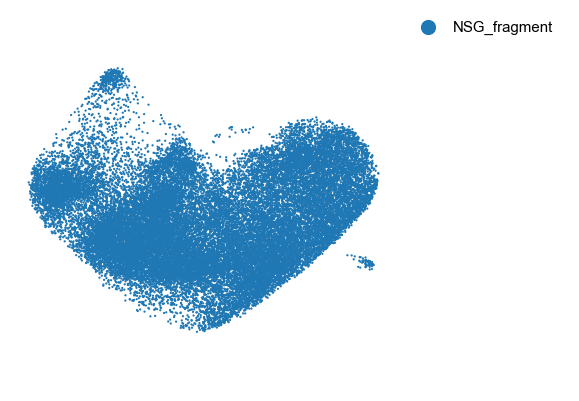

In [24]:
draw_scatter_groups(Xs.obsm['X_umap_pca'], 
                    Xs.obs['tumor'], 
                    s=5, show_axes = False)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

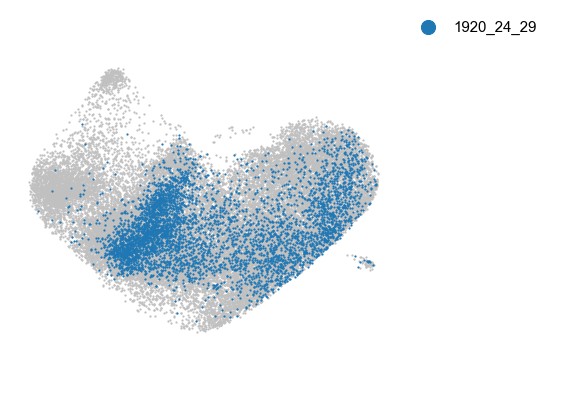

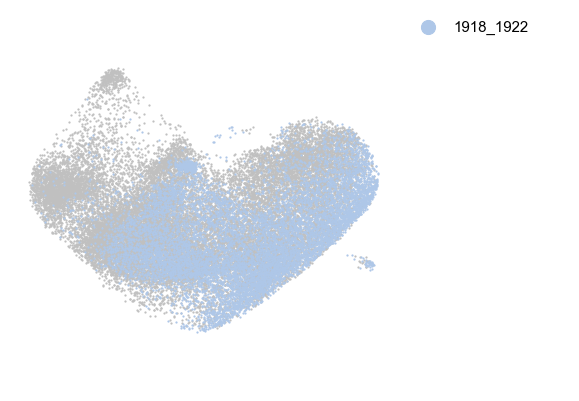

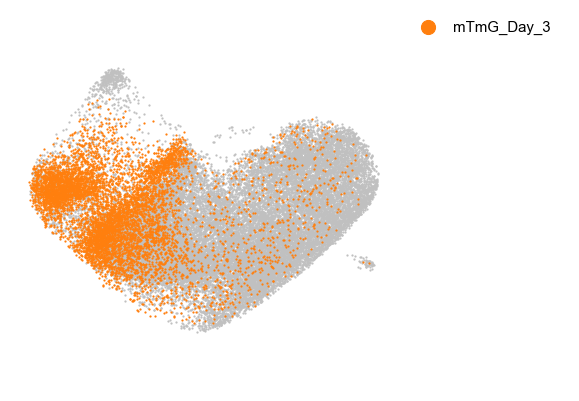

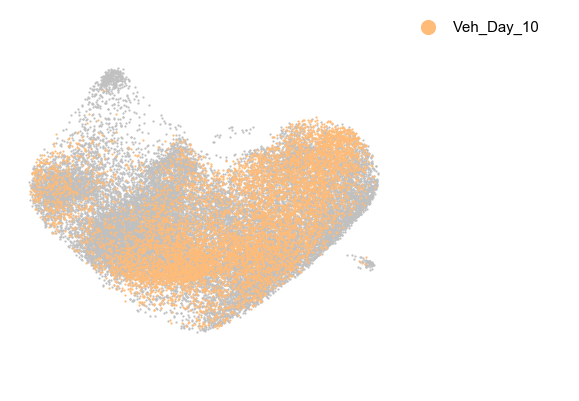

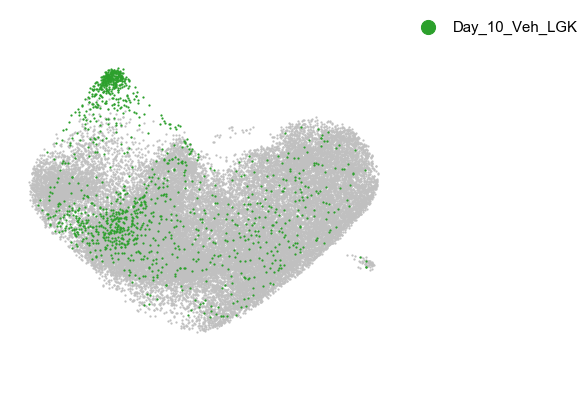

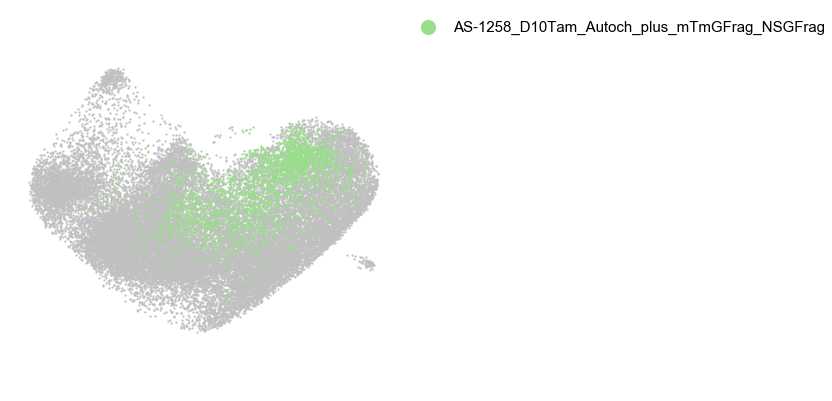

In [25]:
draw_scatter_groups_individual(Xs.obsm['X_umap_pca'], 
                               Xs.obs['batch'], 
                               s=5, show_axes = False)

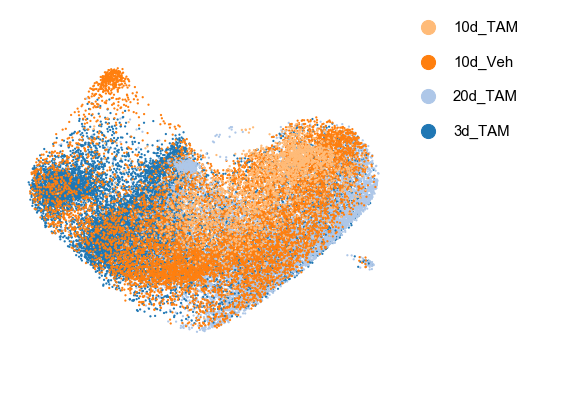

In [26]:
draw_scatter_groups(Xs.obsm['X_umap_pca'], 
                    Xs.obs['treatment'],
                    s=5, show_axes = False)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

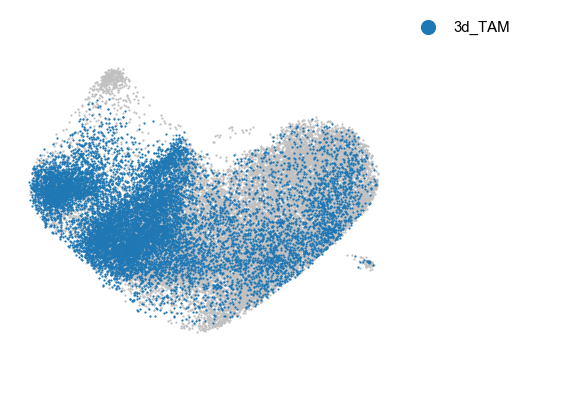

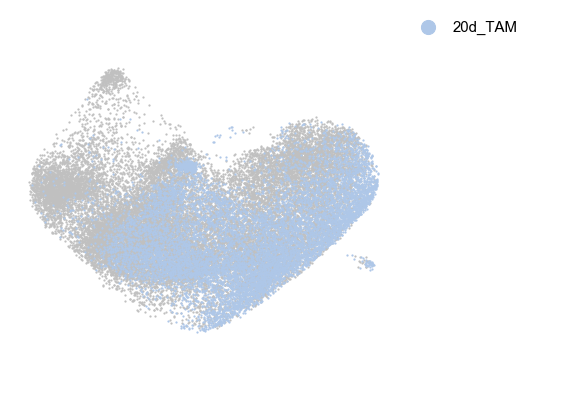

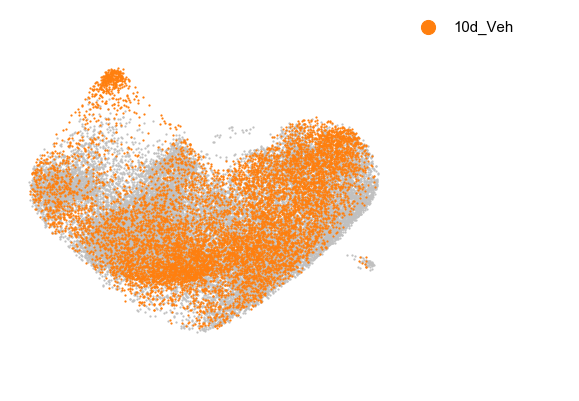

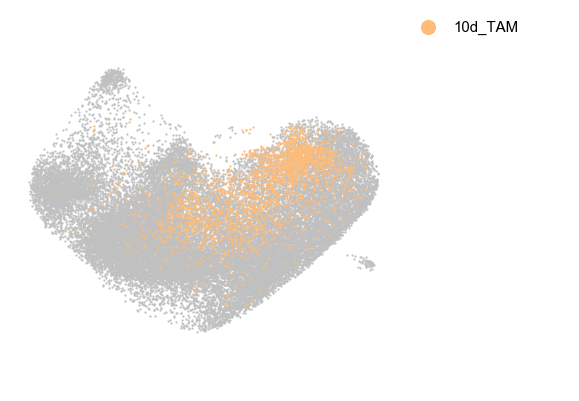

In [27]:
draw_scatter_groups_individual(Xs.obsm['X_umap_pca'], 
                    Xs.obs['treatment'],
                    s=5, show_axes = False)

## Marker genes - PCA projection

In [28]:
pdX = sc2pd(X, 'norm_log2')

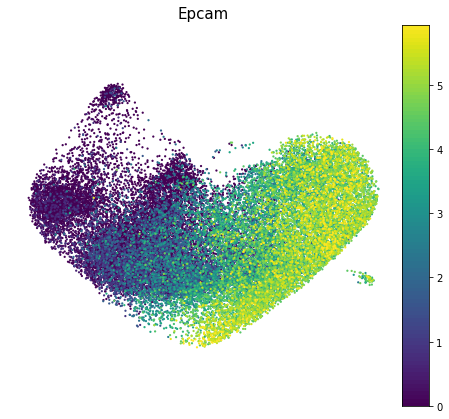

In [26]:
g = 'Epcam'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

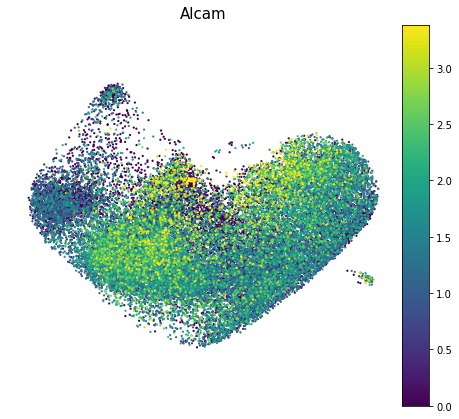

In [27]:
g = 'Alcam'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

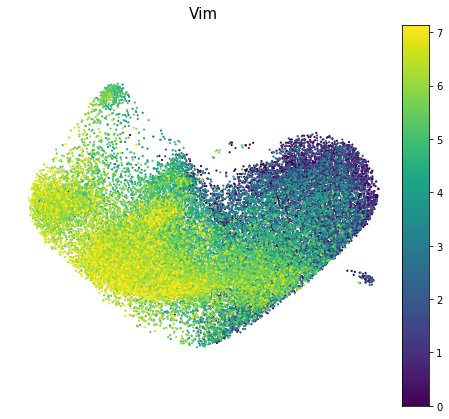

In [28]:
g = 'Vim'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

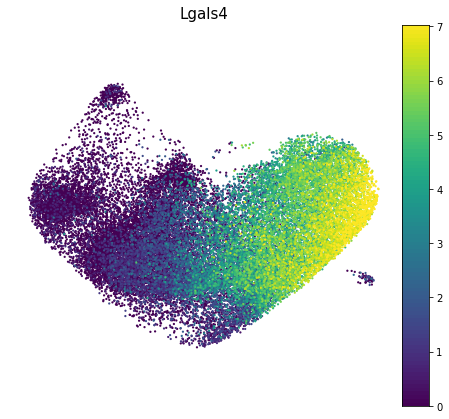

In [29]:
g = 'Lgals4'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

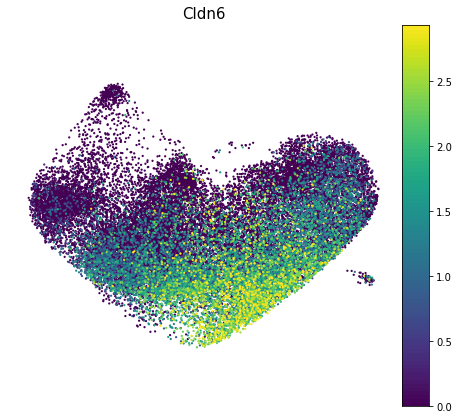

In [30]:
g = 'Cldn6'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

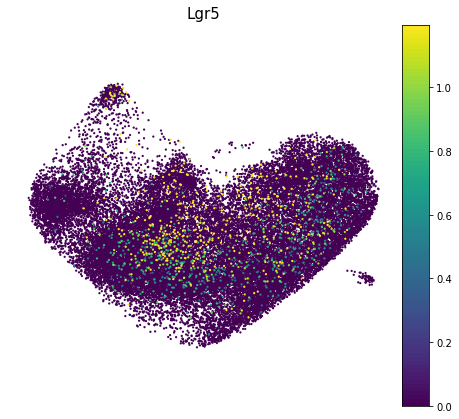

In [31]:
g = 'Lgr5'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

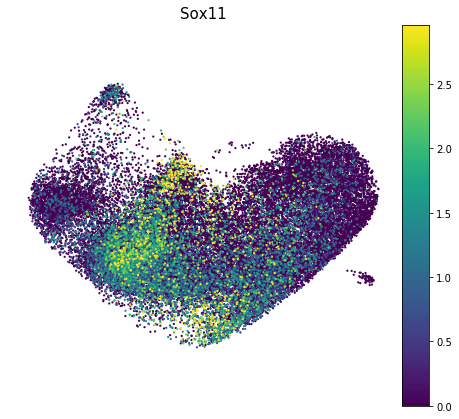

In [32]:
g = 'Sox11'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

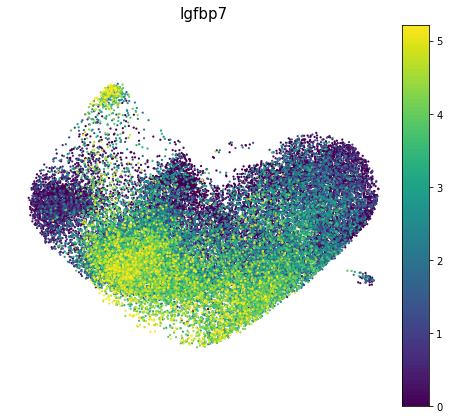

In [33]:
g = 'Igfbp7'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

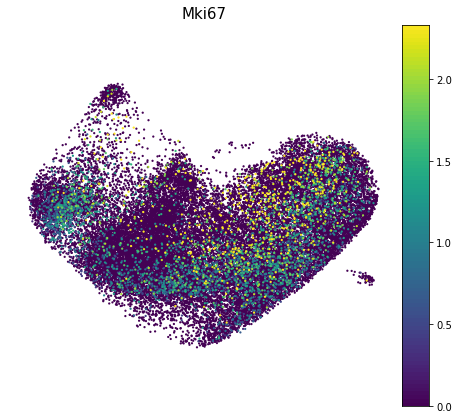

In [34]:
g = 'Mki67'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

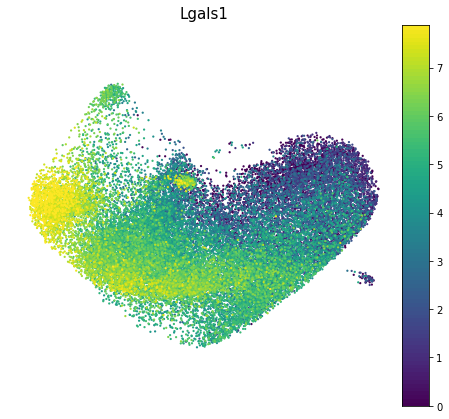

In [35]:
g = 'Lgals1'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

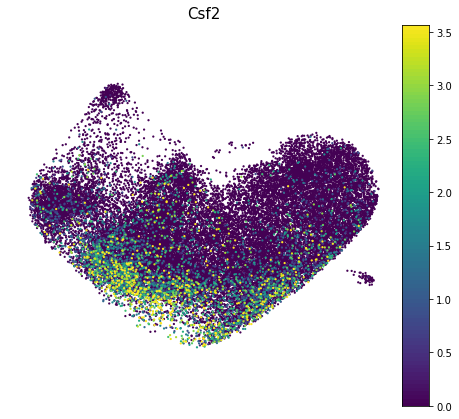

In [36]:
g = 'Csf2'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 5, show_axes=False)

## Stratify according to GFP expression

In [29]:
c_sel1 = Xs.obs['batch'][Xs.obs['batch']=='1920_24_29'].index
c_sel2 = Xs.obs['batch'][Xs.obs['batch']=='1918_1922'].index
c_sel3 = Xs.obs['batch'][Xs.obs['batch']=='mTmG_Day_3'].index
c_sel4 = Xs.obs['batch'][Xs.obs['batch']=='Veh_Day_10'].index
c_sel5 = Xs.obs['batch'][Xs.obs['batch']=='Day_10_Veh_LGK'].index
c_sel6 = Xs.obs['batch'][Xs.obs['batch']==' '].index

In [30]:
dat = Xs.obs[['tdTomato','GFP']].T / Xs.obs['size_factor']

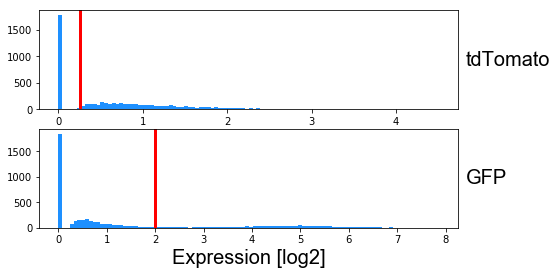

In [31]:
plot_hashes(dat[c_sel1], thr = [0.25,2])

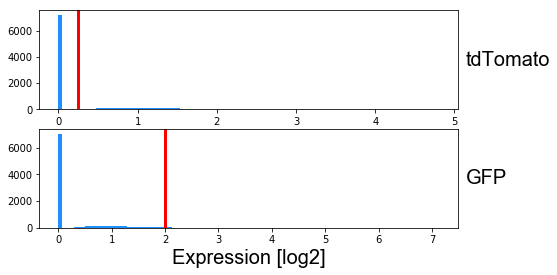

In [32]:
plot_hashes(dat[c_sel2], thr = [0.25,2])

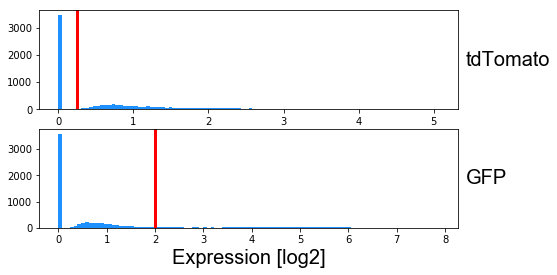

In [33]:
plot_hashes(dat[c_sel3], thr = [0.25,2])

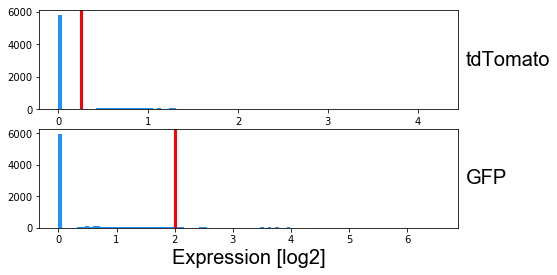

In [34]:
plot_hashes(dat[c_sel4], thr = [0.25,2])

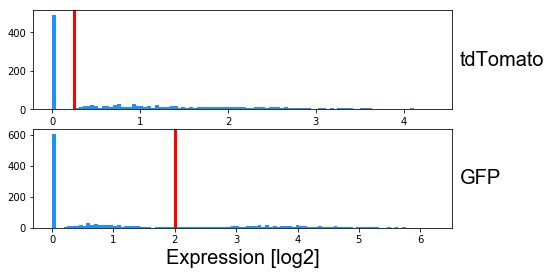

In [35]:
plot_hashes(dat[c_sel5], thr = [0.25,2])

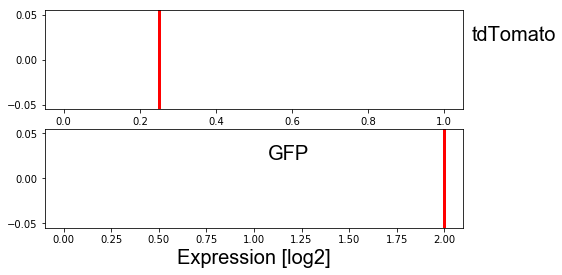

In [36]:
plot_hashes(dat[c_sel6], thr = [0.25,2])

In [37]:
Xs.obs['lineage_tracing'] = assign_hashes(dat, thr = [0.25,2])
Xs.obs['lineage_tracing2'] = Xs.obs['lineage_tracing']
Xs.obs['lineage_tracing2'][Xs.obs['lineage_tracing2']=='tdTomato-GFP'] = 'GFP'

Trying to set attribute `.obs` of view, copying.
/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
Counter(Xs.obs['lineage_tracing'][c_sel1])

Counter({'tdTomato': 1950, 'Negative': 1553, 'tdTomato-GFP': 1054, 'GFP': 240})

In [39]:
Counter(Xs.obs['lineage_tracing'][c_sel2])

Counter({'Negative': 6987, 'tdTomato': 2113, 'GFP': 234, 'tdTomato-GFP': 526})

In [40]:
Counter(Xs.obs['lineage_tracing'][c_sel3])

Counter({'Negative': 3204, 'tdTomato-GFP': 862, 'GFP': 291, 'tdTomato': 2721})

In [41]:
Counter(Xs.obs['lineage_tracing'][c_sel4])

Counter({'Negative': 5642, 'tdTomato': 1684, 'GFP': 167, 'tdTomato-GFP': 548})

In [42]:
Counter(Xs.obs['lineage_tracing'][c_sel5])

Counter({'Negative': 469, 'tdTomato': 475, 'tdTomato-GFP': 349, 'GFP': 21})

In [43]:
Counter(Xs.obs['lineage_tracing'][c_sel6])

Counter()

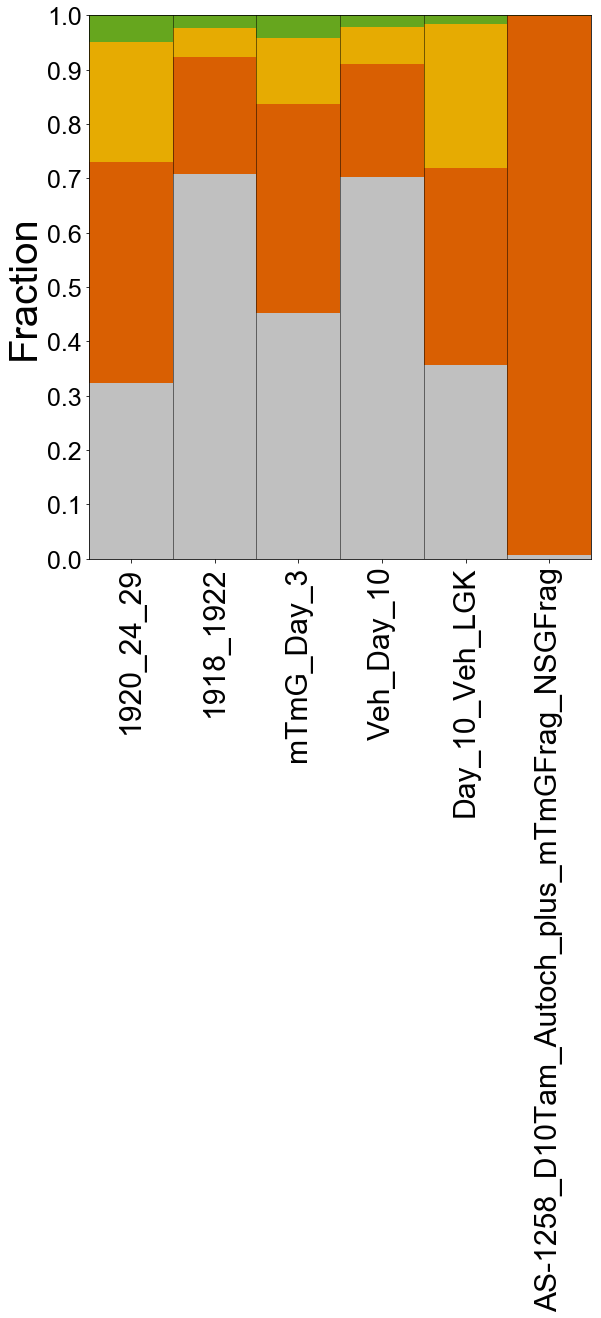

In [44]:
draw_fraction_cluster(Xs.obs['batch'], 
                      Xs.obs['lineage_tracing'], 
                      cmap_lineage_tracing, var_order=['Negative','tdTomato','tdTomato-GFP','GFP'])

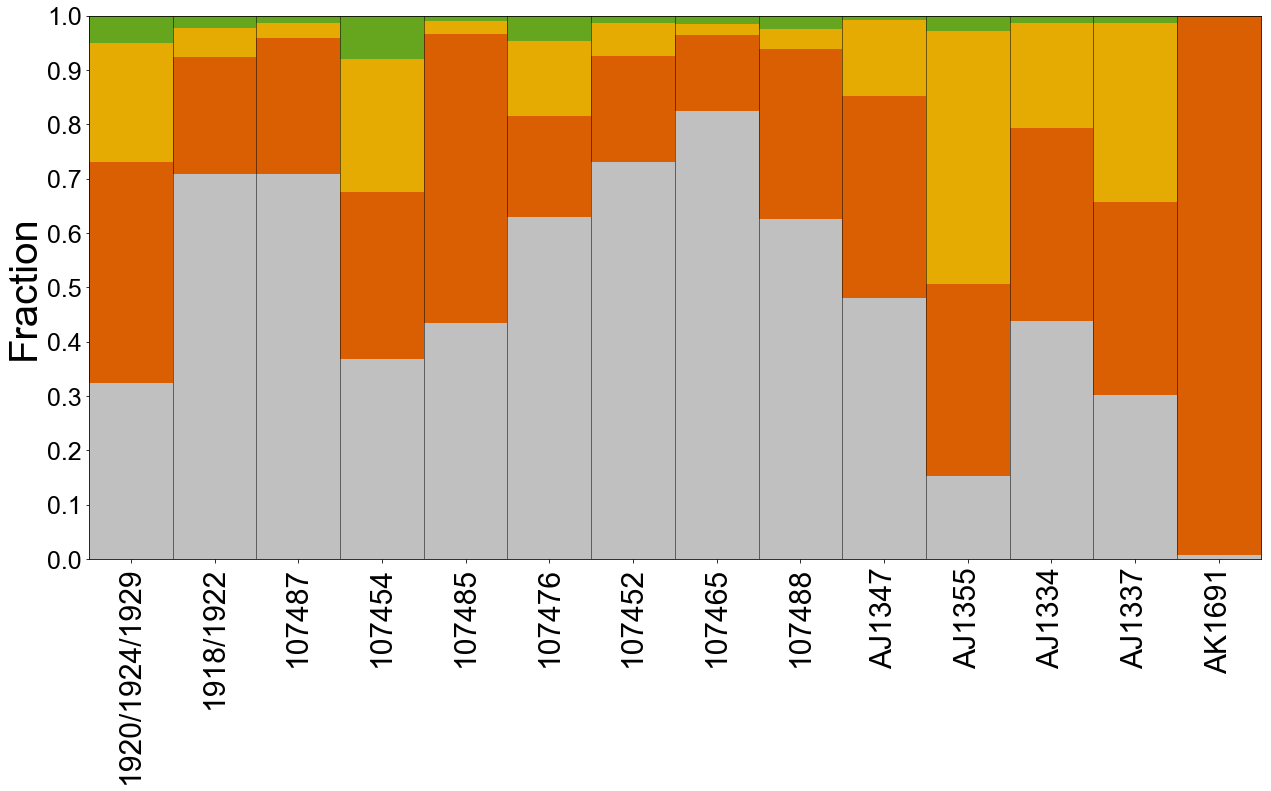

In [45]:
draw_fraction_cluster(Xs.obs['mouse'], 
                      Xs.obs['lineage_tracing'], 
                      cmap_lineage_tracing, var_order=['Negative','tdTomato','tdTomato-GFP','GFP'])

## Lgr5 expression in lineage tracing groups stratified according to batch

In [46]:
def draw_bars(data, groups, cmap=plt.cm.tab20, gr_order=None, scatter=False, ylim=None):
    
    if not gr_order:
        gr_order = return_unique(groups)
        
    L = len(gr_order)
    
    #initialize figure

    height = 6
    width = 2 * L

    plt.figure(facecolor = 'w', figsize = (width, height))
    
    #define colormap
    
    if type(cmap) != dict:
        cm = cmap
        cmap = {}
        for ix, gr in enumerate(return_unique(groups)):
            cmap[gr] = cm(float(ix) / 20)
            
    clist = [cmap[groups[c]] for c in groups.index]

    #define x and y axes

    ax = plt.subplot()

    ax.set_xlim(-0.5, L-0.5)
    ax.set_xticks(range(L))
    ax.set_xticklabels(gr_order, family = 'Arial', fontsize = 25, rotation = 'vertical')

    ax.set_ylabel('Mean expression', family = 'Arial', fontsize = 25)
    if ylim:
        ax.set_ylim(ylim)
    for tick_pos, tick in enumerate(ax.yaxis.get_major_ticks()):
            ax.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
            ax.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(20)

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    #plot data

    for p, i in enumerate(gr_order):

        i_tmp = groups[groups==i].index
        d_tmp = data[i_tmp].values
        
        ax.bar(p, d_tmp.mean(), color = cmap[i], yerr = d_tmp.std()/np.sqrt(len(d_tmp)))

## 1920_24_29

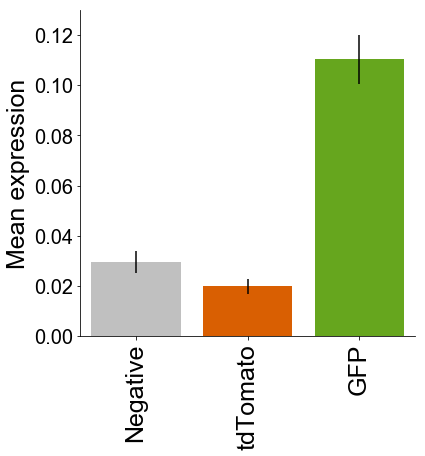

In [61]:
draw_bars(sc2pd(X,'norm_log2')[c_sel1].loc['Lgr5'],
          Xs.obs['lineage_tracing2'][c_sel1],
          cmap=cmap_lineage_tracing,
          gr_order=['Negative','tdTomato','GFP'],
          scatter=True, ylim=(0,0.13))

### 1918_1922

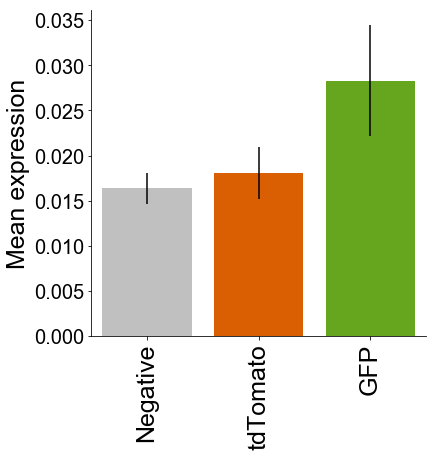

In [62]:
draw_bars(sc2pd(X,'norm_log2')[c_sel2].loc['Lgr5'],
          Xs.obs['lineage_tracing2'][c_sel2],
          cmap=cmap_lineage_tracing,
          gr_order=['Negative','tdTomato','GFP'],
          scatter=True)

### mTmG_Day_3

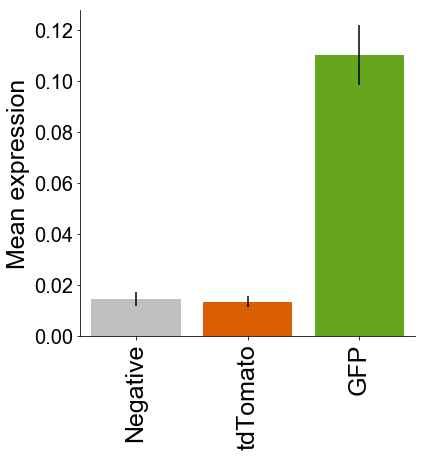

In [63]:
draw_bars(sc2pd(X,'norm_log2')[c_sel3].loc['Lgr5'],
          Xs.obs['lineage_tracing2'][c_sel3],
          cmap=cmap_lineage_tracing,
          gr_order=['Negative','tdTomato','GFP'],
          scatter=True)

### Veh_Day_10

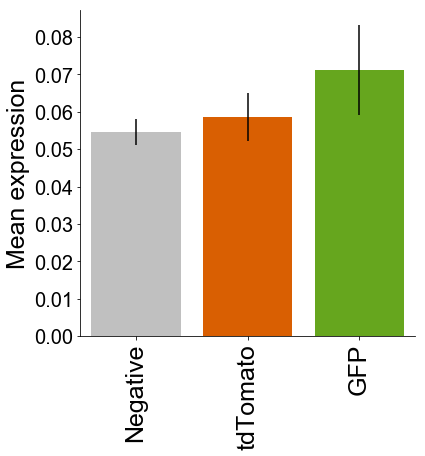

In [64]:
draw_bars(sc2pd(X,'norm_log2')[c_sel4].loc['Lgr5'],
          Xs.obs['lineage_tracing2'][c_sel4],
          cmap=cmap_lineage_tracing,
          gr_order=['Negative','tdTomato','GFP'],
          scatter=True)

### Day_10_Veh_LGK

In [65]:
draw_bars(sc2pd(X,'norm_log2')[c_sel5].loc['Lgr5'],
          Xs.obs['lineage_tracing2'][c_sel5],
          cmap=cmap_lineage_tracing,
          gr_order=['Negative','tdTomato','GFP'],
          scatter=True)

KeyError: "None of [Index(['AAACCCATCACGTCCT-18', 'AAACGAACACCAGCGT-18', 'AAACGAAGTTGTCCCT-18',\n       'AAACGCTAGAAATTCG-18', 'AAACGCTCAGTCGGTC-18', 'AAAGAACAGTAGTCAA-18',\n       'AAAGAACAGTCGGCAA-18', 'AAAGAACGTTATCTTC-18', 'AAAGGATAGCTAGCCC-18',\n       'AAAGGATCAGGTTACT-18',\n       ...\n       'TTTGACTCACATATGC-18', 'TTTGATCCAATCGCCG-18', 'TTTGGAGAGTATGGCG-18',\n       'TTTGGAGGTCACCCTT-18', 'TTTGGAGGTCACCGCA-18', 'TTTGGAGTCTGGCCAG-18',\n       'TTTGTTGGTATCTCGA-18', 'ACGGGTCCAACGAGGT-18', 'AGGACTTGTTAGGACG-18',\n       'GAACTGTGTGTACAGG-18'],\n      dtype='object', length=1314)] are in the [index]"

In [ ]:
draw_bars(sc2pd(X,'norm_log2')[c_sel6].loc['Lgr5'],
          Xs.obs['lineage_tracing2'][c_sel6],
          cmap=cmap_lineage_tracing,
          gr_order=['Negative','tdTomato','GFP'],
          scatter=True)

## Batches 'Day_10_Veh_LGK' and 'AS-1258_D10Tam_Autoch_plus_mTmGFrag_NSGFrag' turned out to be low quality --> remove

In [ ]:
 c_sel = Xs.obs[~Xs.obs['batch'].isin(['Day_10_Veh_LGK','AS-1258_D10Tam_Autoch_plus_mTmGFrag_NSGFrag'])].index

In [ ]:
len(c_sel)

In [ ]:
Xs = Xs[c_sel]

# Lgr5 expression in lineage tracing groups stratified according to tracing time

In [ ]:
def draw_bars_fc(data, groups, cmap=plt.cm.tab20, gr_order=None, scatter=False, ylim=None, ref=None):
    
    if not gr_order:
        gr_order = return_unique(groups)
        
    if not ref:
        ref = gr_order[0]
        
    L = len(gr_order)
    
    #initialize figure

    height = 6
    width = 2 * L

    plt.figure(facecolor = 'w', figsize = (width, height))
    
    #define colormap
    
    if type(cmap) != dict:
        cm = cmap
        cmap = {}
        for ix, gr in enumerate(return_unique(groups)):
            cmap[gr] = cm(float(ix) / 20)
            
    clist = [cmap[groups[c]] for c in groups.index]

    #define x and y axes

    ax = plt.subplot()

    ax.set_xlim(-0.5, L-0.5)
    ax.set_xticks(range(L))
    ax.set_xticklabels(gr_order, family = 'Arial', fontsize = 35, rotation = 'vertical')

    ax.set_ylabel('Fold change', family = 'Arial', fontsize = 35)
    if ylim:
        ax.set_ylim(ylim)
    for tick_pos, tick in enumerate(ax.yaxis.get_major_ticks()):
            ax.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
            ax.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(25)

    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    #get ref data
    
    i_ref = groups[groups==ref].index
    d_ref = data[i_ref].values
    
    #plot data

    for p, i in enumerate(gr_order):

        i_tmp = groups[groups==i].index
        d_tmp = data[i_tmp].values
        
        ax.bar(p, d_tmp.mean()/d_ref.mean(), color = cmap[i], yerr = d_tmp.std()/np.sqrt(len(d_tmp)))

In [ ]:
c_sel_3d = Xs.obs['treatment'][Xs.obs['treatment']=='3d_TAM'].index
c_sel_10d = Xs.obs['treatment'][Xs.obs['treatment']=='10d_Veh'].index
c_sel_20d = Xs.obs['treatment'][Xs.obs['treatment']=='20d_TAM'].index

### 3d TAM

In [ ]:
draw_bars_fc(sc2pd(X,'norm_log2')[c_sel_3d].loc['Lgr5'],
          Xs.obs['lineage_tracing2'][c_sel_3d],
          cmap=cmap_lineage_tracing,
          gr_order=['tdTomato','GFP'],
          scatter=True, ylim=(0,10))

figname = 'bar_Lgr5_expr_3d.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

### 10d TAM

In [ ]:
draw_bars_fc(sc2pd(X,'norm_log2')[c_sel_10d].loc['Lgr5'],
          Xs.obs['lineage_tracing2'][c_sel_10d],
          cmap=cmap_lineage_tracing,
          gr_order=['tdTomato','GFP'],
          scatter=True, ylim=(0,10))

figname = 'bar_Lgr5_expr_10d.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

### 20d TAM

In [ ]:
draw_bars_fc(sc2pd(X,'norm_log2')[c_sel_20d].loc['Lgr5'],
          Xs.obs['lineage_tracing2'][c_sel_20d],
          cmap=cmap_lineage_tracing,
          gr_order=['tdTomato','GFP'],
          scatter=True, ylim=(0,10))

figname = 'bar_Lgr5_expr_20d.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

# Projection of lineage tracing on UMAP

### All cells

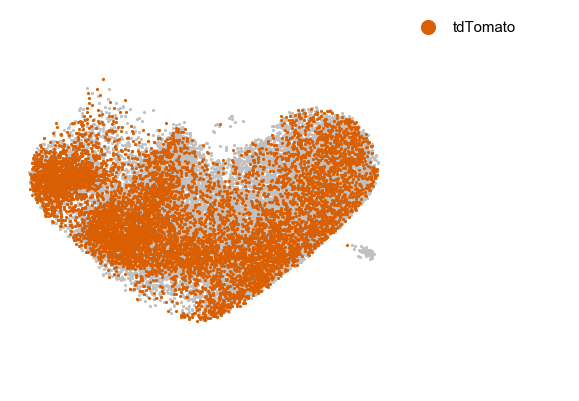

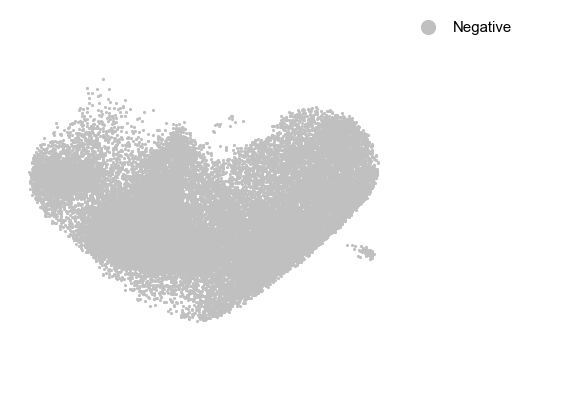

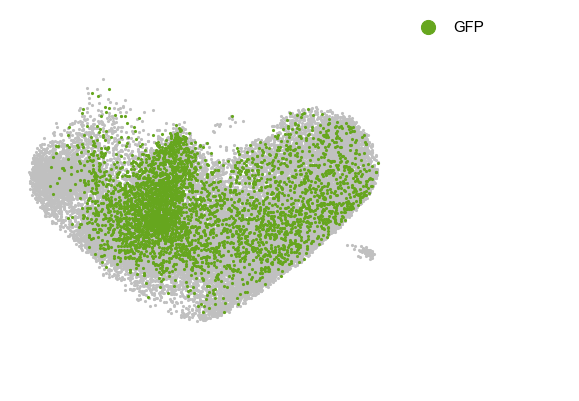

In [76]:
draw_scatter_groups_individual(Xs.obsm['X_umap_pca'], 
                    Xs.obs['lineage_tracing2'],
                    cmap=cmap_lineage_tracing,
                    s=10, show_axes = False)

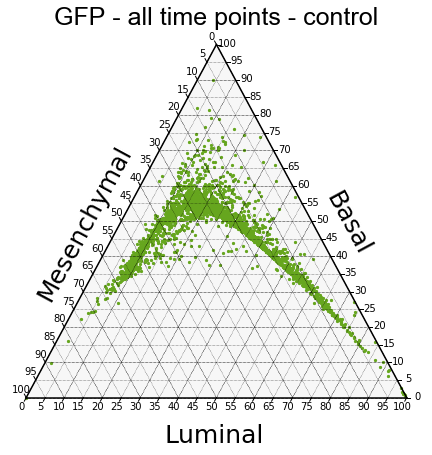

In [77]:
c_sel = Xs.obs[(Xs.obs['lineage_tracing2']=='GFP')].index
dat = list(zip(Xs[c_sel].obs['pheno_prob0_pca']*100, 
               Xs[c_sel].obs['pheno_prob1_pca']*100,
               Xs[c_sel].obs['pheno_prob2_pca']*100))
cmap = cmap_lineage_tracing
clist = cmap['GFP']

## Boundary and Gridlines
scale = 100
figure, tax = ternary.figure(scale=scale)
figure.set_figheight(7.5)
figure.set_figwidth(7.5)

# Draw Boundary and Gridlines
tax.boundary(linewidth=1.5)
tax.gridlines(color="black", multiple=10)
tax.gridlines(color="black", multiple=5, linewidth=0.5)

# Set Axis labels and Title
fontsize = 25
offset = 0.1
tax.set_title('GFP - all time points - control', fontsize=fontsize, family='Arial')
tax.left_axis_label("Mesenchymal", fontsize=fontsize, offset=offset)
tax.right_axis_label("Basal", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("Luminal", fontsize=fontsize, offset=0.025)

# Set ticks
tax.ticks(axis='lbr', linewidth=1, multiple=5, offset=0.01)

# Background color
tax.set_background_color(color="whitesmoke", alpha=0.7) # the detault, essentially

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

#plot scatter

tax.scatter(dat, s=5, color = clist)

### 3 day

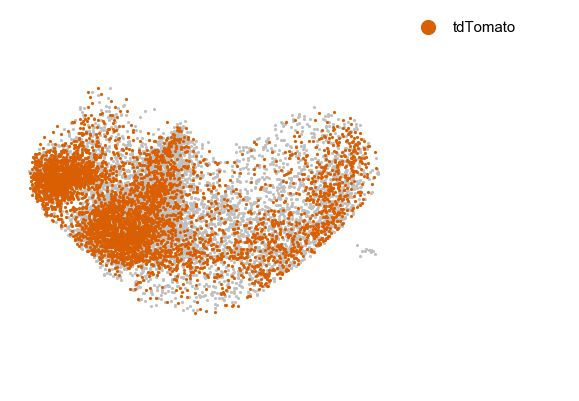

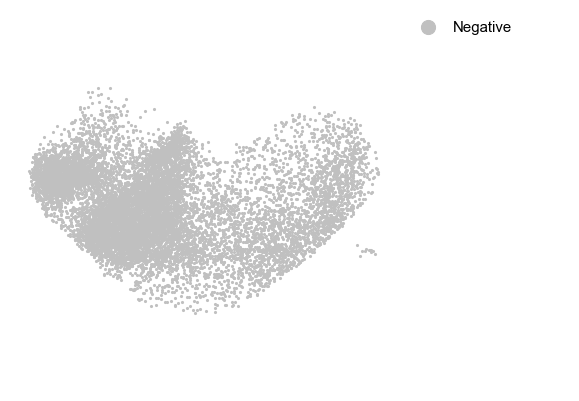

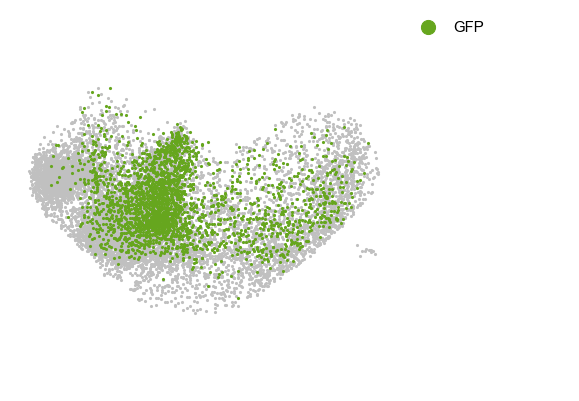

In [78]:
draw_scatter_groups_individual(Xs[c_sel_3d].obsm['X_umap_pca'], 
                    Xs.obs['lineage_tracing2'][c_sel_3d],
                    cmap=cmap_lineage_tracing,
                    s=10, show_axes = False)

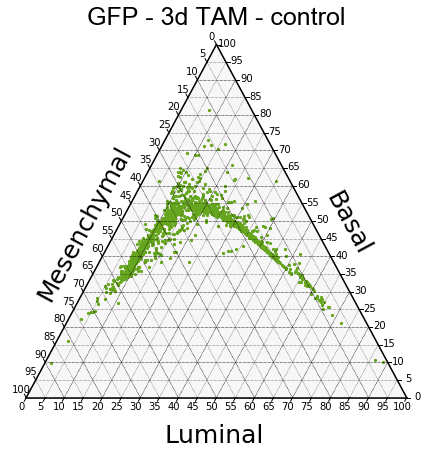

In [79]:
c_sel = Xs[c_sel_3d].obs[(Xs[c_sel_3d].obs['lineage_tracing2']=='GFP')].index
dat = list(zip(Xs[c_sel].obs['pheno_prob0_pca']*100, 
               Xs[c_sel].obs['pheno_prob1_pca']*100,
               Xs[c_sel].obs['pheno_prob2_pca']*100))
cmap = cmap_lineage_tracing
clist = cmap['GFP']

## Boundary and Gridlines
scale = 100
figure, tax = ternary.figure(scale=scale)
figure.set_figheight(7.5)
figure.set_figwidth(7.5)

# Draw Boundary and Gridlines
tax.boundary(linewidth=1.5)
tax.gridlines(color="black", multiple=10)
tax.gridlines(color="black", multiple=5, linewidth=0.5)

# Set Axis labels and Title
fontsize = 25
offset = 0.1
tax.set_title('GFP - 3d TAM - control', fontsize=fontsize, family='Arial')
tax.left_axis_label("Mesenchymal", fontsize=fontsize, offset=offset)
tax.right_axis_label("Basal", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("Luminal", fontsize=fontsize, offset=0.025)

# Set ticks
tax.ticks(axis='lbr', linewidth=1, multiple=5, offset=0.01)

# Background color
tax.set_background_color(color="whitesmoke", alpha=0.7) # the detault, essentially

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

#plot scatter

tax.scatter(dat, s=5, color = clist)

### 10 day

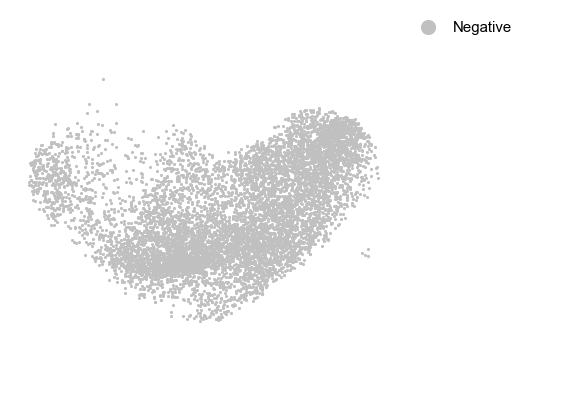

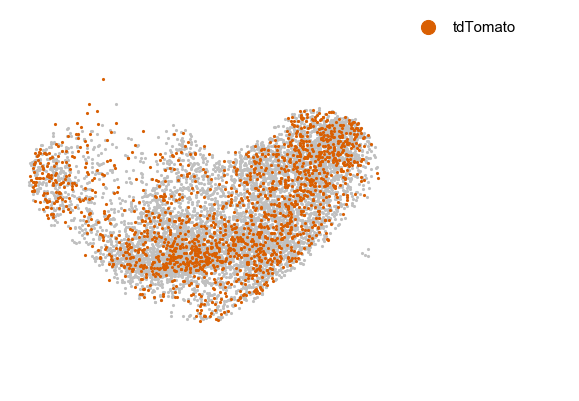

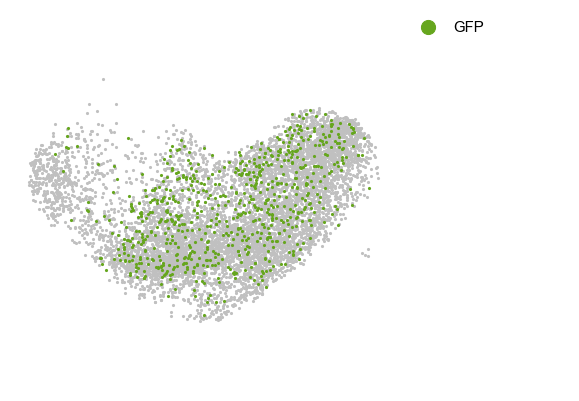

In [80]:
draw_scatter_groups_individual(Xs[c_sel_10d].obsm['X_umap_pca'], 
                    Xs.obs['lineage_tracing2'][c_sel_10d],
                    cmap=cmap_lineage_tracing,
                    s=10, show_axes = False)

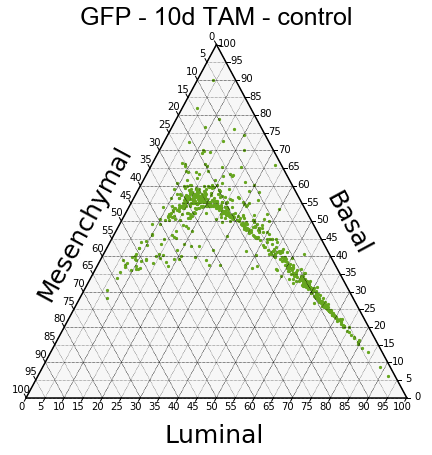

In [81]:
c_sel = Xs[c_sel_10d].obs[(Xs[c_sel_10d].obs['lineage_tracing2']=='GFP')].index
dat = list(zip(Xs[c_sel].obs['pheno_prob0_pca']*100, 
               Xs[c_sel].obs['pheno_prob1_pca']*100,
               Xs[c_sel].obs['pheno_prob2_pca']*100))
cmap = cmap_lineage_tracing
clist = cmap['GFP']

## Boundary and Gridlines
scale = 100
figure, tax = ternary.figure(scale=scale)
figure.set_figheight(7.5)
figure.set_figwidth(7.5)

# Draw Boundary and Gridlines
tax.boundary(linewidth=1.5)
tax.gridlines(color="black", multiple=10)
tax.gridlines(color="black", multiple=5, linewidth=0.5)

# Set Axis labels and Title
fontsize = 25
offset = 0.1
tax.set_title('GFP - 10d TAM - control', fontsize=fontsize, family='Arial')
tax.left_axis_label("Mesenchymal", fontsize=fontsize, offset=offset)
tax.right_axis_label("Basal", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("Luminal", fontsize=fontsize, offset=0.025)

# Set ticks
tax.ticks(axis='lbr', linewidth=1, multiple=5, offset=0.01)

# Background color
tax.set_background_color(color="whitesmoke", alpha=0.7) # the detault, essentially

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

#plot scatter

tax.scatter(dat, s=5, color = clist)

### 20 day

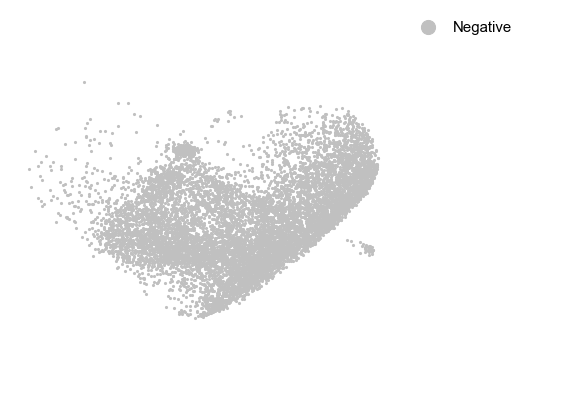

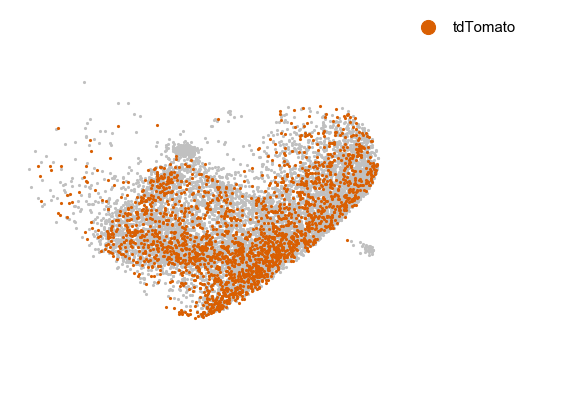

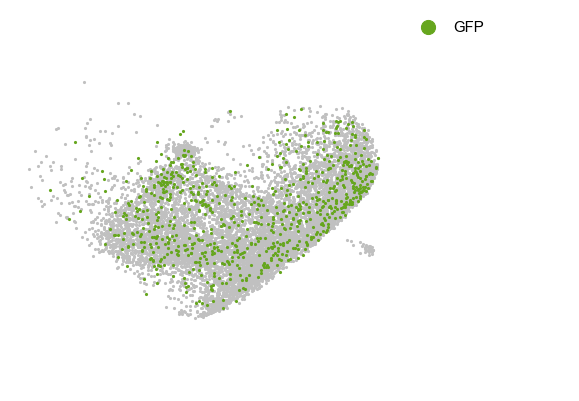

In [82]:
draw_scatter_groups_individual(Xs[c_sel_20d].obsm['X_umap_pca'], 
                    Xs.obs['lineage_tracing2'][c_sel_20d],
                    cmap=cmap_lineage_tracing,
                    s=10, show_axes = False)

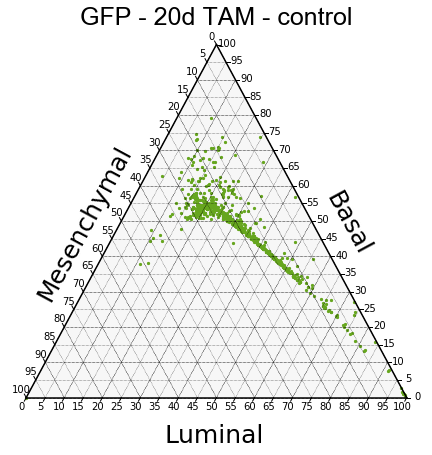

In [83]:
c_sel = Xs[c_sel_20d].obs[(Xs[c_sel_20d].obs['lineage_tracing2']=='GFP')].index
dat = list(zip(Xs[c_sel].obs['pheno_prob0_pca']*100, 
               Xs[c_sel].obs['pheno_prob1_pca']*100,
               Xs[c_sel].obs['pheno_prob2_pca']*100))
cmap = cmap_lineage_tracing
clist = cmap['GFP']

## Boundary and Gridlines
scale = 100
figure, tax = ternary.figure(scale=scale)
figure.set_figheight(7.5)
figure.set_figwidth(7.5)

# Draw Boundary and Gridlines
tax.boundary(linewidth=1.5)
tax.gridlines(color="black", multiple=10)
tax.gridlines(color="black", multiple=5, linewidth=0.5)

# Set Axis labels and Title
fontsize = 25
offset = 0.1
tax.set_title('GFP - 20d TAM - control', fontsize=fontsize, family='Arial')
tax.left_axis_label("Mesenchymal", fontsize=fontsize, offset=offset)
tax.right_axis_label("Basal", fontsize=fontsize, offset=offset)
tax.bottom_axis_label("Luminal", fontsize=fontsize, offset=0.025)

# Set ticks
tax.ticks(axis='lbr', linewidth=1, multiple=5, offset=0.01)

# Background color
tax.set_background_color(color="whitesmoke", alpha=0.7) # the detault, essentially

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

#plot scatter

tax.scatter(dat, s=5, color = clist)

# Compositional differences in lineage tracing samples

In [53]:
def calculate_cell_density(coords, groups, 
                           kernel='gaussian', bw=0.5,
                           msk_kernel='tophat', msk_bw=1, 
                           n_bins=500, pad=2, 
                           quant_trans=True):
    
    from sklearn.neighbors import KernelDensity
    from sklearn.preprocessing import quantile_transform
    
    #define x- and y-limits

    x_min, x_max = np.min(coords[:,0]), np.max(coords[:,0])
    y_min, y_max = np.min(coords[:,1]), np.max(coords[:,1])
    x_diff, y_diff = x_max - x_min, y_max - y_min
    x_cent, y_cent = x_min + 0.5 * x_diff, y_min + 0.5 * y_diff,

    pad = pad

    if x_diff > y_diff:
        xlim = (x_min - pad, x_max + pad)
        ylim = (y_cent - 0.5 * x_diff - pad, y_cent + 0.5 * x_diff + pad,)

    if x_diff < y_diff:
        xlim = (x_cent - 0.5 * y_diff - pad, x_cent + 0.5 * y_diff + pad)
        ylim = (y_min - pad, y_max + pad)
        
    #create grid for scoring
    
    x = np.linspace(xlim[0], xlim[1], n_bins)
    y = np.linspace(ylim[0], ylim[1], n_bins)
    X,Y = np.meshgrid(y, x)
    xy = np.vstack([Y.ravel(), X.ravel()]).T
    
    #fit KDE over complete dataset to define mask
    
    kde = KernelDensity(kernel=msk_kernel, bandwidth=msk_bw).fit(coords)    
    Z = np.exp(kde.score_samples(xy))
    mask = np.isclose(Z,0)
    
    #define ouput
    
    out = pd.DataFrame(index = tuple(xy), columns = return_unique(groups))
    
    #fit KDE over groups 
    
    for g in return_unique(groups):
        kde = KernelDensity(kernel=kernel, bandwidth=bw).fit(coords[groups==g])    
        Z = np.exp(kde.score_samples(xy))
        Z[mask] = None #set none to not condsider in scaling
        out[g] = Z
        
    #quantile transform
    
    if quant_trans:
        out = pd.DataFrame(quantile_transform(out), index = out.index, columns = out.columns)
        
    #out = out.fillna(0)
    
    return out

In [54]:
def draw_density(dens, limits=None, text = None,  cmap = plt.cm.viridis, pad = 2, s = 50, 
                 show_axes = True, show_legend=True, label=None, plot_entropy=False):
    
    dat = dens
        
    if type(limits) == tuple:
        vmin,vmax = limits[0], limits[1]
        dat = np.clip(dat, a_min=vmin, a_max=vmax)
    else:
        abs_ = np.max(np.abs([dat.min(), dat.max()]))
        vmin,vmax = -abs_, abs_
    
    shape = int(np.sqrt(len(dat)))
    dat = np.reshape(dat.values, newshape=(shape,shape))

    x = np.array([i[0] for i in dens.index])
    X = np.reshape(x, newshape=(shape,shape))

    y = np.array([i[1] for i in dens.index])
    Y = np.reshape(y, newshape=(shape,shape))
    
    #initialize figure

    height = 7
    width = 7.5
    plt.figure(facecolor = 'w', figsize = (width, height))
    gs = plt.GridSpec(1,2, wspace=0.25, width_ratios=[7,.5])
    
    ax = plt.subplot(gs[0])
    
    #plot data
    ax.contourf(X, Y, dat, levels=np.linspace(vmin, vmax, 1000), cmap=cmap)

    #text
    
    xlim=ax.get_xlim()
    ylim=ax.get_ylim()
    
    if text:
        ax.text(xlim[0] + (xlim[1]-xlim[0]) / 2,
                ylim[1] * 1.1,
                text,
                family='Arial',
                fontsize = 20, va = 'center', ha = 'center')
        
    if not show_axes:
        clean_axis(ax)
        
    #plot Shannon entropy
    
    if plot_entropy:
        ent = scipy.stats.entropy(dens[~np.isnan(dens)].values)
        ax.text(xlim[0] + (xlim[1]-xlim[0]) / 2,
                ylim[1] * 1.025,
                'H(X) = %s' % ent,
                family='Arial',
                fontsize = 15, va = 'center', ha = 'center')
    
    #plot colorbar
    
    if show_legend:

        ax = plt.subplot(gs[1])

        ax.set_xlim(0,1)
        ax.set_xticks([])

        ax.set_ylim(vmin, vmax)
        ax.yaxis.set_ticks_position('right')
        
        ax.set_ylabel(label, family='Arial', fontsize=30)
        ax.yaxis.set_label_position('right')
        
        for i in np.linspace(vmin, vmax, 100):
            ax.axhspan(i, i + (vmax-vmin) / 100, color = cmap((i-vmin)/(vmax-vmin)))

In [66]:
def draw_density_vs(dens, vs, limits= None, text = None,  cmap = plt.cm.viridis, pad = 2, s = 50, 
                    show_axes = True, show_legend=True):
    
    if type(vs) == list:
        assert len(vs) == 2, 'vs must contain two keys'
        dat = dens[vs[0]] - dens[vs[1]]      
    elif type(vs) == str:
        dat = dens[vs] - dens[[i for i in dens.columns if i != vs]].mean(axis=1)
        vs = [vs, 'other']

    if type(limits) == tuple:
        vmin,vmax = limits[0], limits[1]
        dat = np.clip(dat, a_min=vmin, a_max=vmax) 
    else:
        abs_ = np.max(np.abs([dat.min(), dat.max()]))
        vmin,vmax = -abs_, abs_
        
    shape = int(np.sqrt(len(dat)))
    dat = np.reshape(dat.values, newshape=(shape,shape))

    x = np.array([i[0] for i in dens.index])
    X = np.reshape(x, newshape=(shape,shape))

    y = np.array([i[1] for i in dens.index])
    Y = np.reshape(y, newshape=(shape,shape))

    #initialize figure

    height = 7
    width = 7.5
    plt.figure(facecolor = 'w', figsize = (width, height))
    gs = plt.GridSpec(1,2, wspace=0.25, width_ratios=[7,.5])
    
    ax = plt.subplot(gs[0])
    
    #plot data

    ax.contourf(X, Y, dat, levels=np.linspace(vmin, vmax, 1000), cmap=cmap)

    #text
    
    xlim=ax.get_xlim()
    ylim=ax.get_ylim()
    
    if text:
        ax.text(xlim[0] + (xlim[1]-xlim[0]) / 2,
                ylim[1] * 1.05,
                text,
                family='Arial',
                fontsize = 20, va = 'center', ha = 'center')
        
    if not show_axes:
        clean_axis(ax)
    
    #plot colorbar
    
    if show_legend:

        ax = plt.subplot(gs[1])

        ax.set_xlim(0,1)
        ax.set_xticks([])

        ax.set_ylim(vmin, vmax)
        #ax.set_yticks([])

        for i in np.linspace(vmin, vmax, 100):
            ax.axhspan(i, i + (vmax-vmin) / 100, color = cmap((i-vmin)/(vmax-vmin)))
            
        ax.text(0.5,vmax+((vmax-vmin)*0.05),vs[0],family='Arial',fontsize=25,ha='center',va='center')
        ax.text(0.5,vmin-((vmax-vmin)*0.05),vs[1],family='Arial',fontsize=25,ha='center',va='center')

In [67]:
LT_time = []
for i in Xs.obs_names:
    if i in c_sel_3d: LT_time.append('%s-3d' % (Xs.obs['lineage_tracing2'][i]))
    elif i in c_sel_10d: LT_time.append('%s-10d' % (Xs.obs['lineage_tracing2'][i]))
    elif i in c_sel_20d: LT_time.append('%s-20d' % (Xs.obs['lineage_tracing2'][i]))

In [68]:
Xs.obs['LT*time'] = LT_time
Xs.obs['LT*mouse'] = ['%s-%s' % (Xs.obs['lineage_tracing2'][i], Xs.obs['mouse'][i]) for i in Xs.obs_names]

Trying to set attribute `.obs` of view, copying.


In [90]:
dens_lineage_tracing = calculate_cell_density(Xs.obsm['X_umap_pca'], Xs.obs['LT*time'], kernel='gaussian',n_bins=100, bw=3, pad = 5, quant_trans=False)

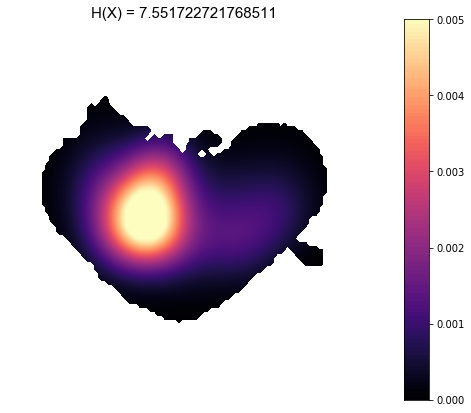

In [91]:
draw_density(dens_lineage_tracing['GFP-3d'],
             cmap=plt.cm.magma, 
             show_axes=False, limits = (0,0.005), plot_entropy=True)

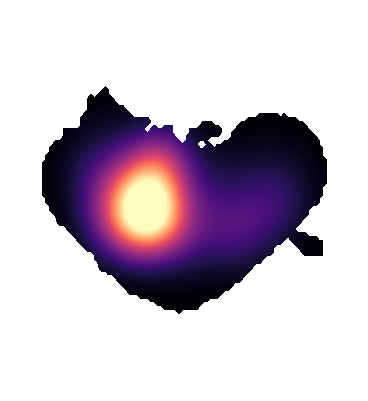

In [93]:
draw_density(dens_lineage_tracing['GFP-3d'],
             cmap=plt.cm.magma, 
             show_axes=False, limits = (0,0.005), plot_entropy=False, show_legend=False)


figname = 'UMAP_frag_density_GFP_3d.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

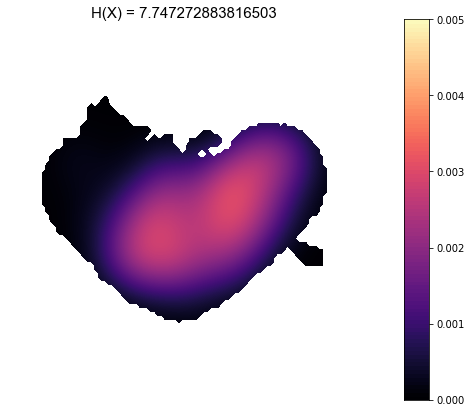

In [94]:
draw_density(dens_lineage_tracing['GFP-10d'], 
             cmap=plt.cm.magma, 
             show_axes=False, limits = (0,0.005), plot_entropy=True)

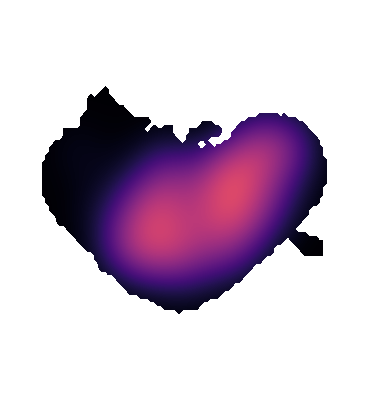

In [95]:
draw_density(dens_lineage_tracing['GFP-10d'],
             cmap=plt.cm.magma, 
             show_axes=False, limits = (0,0.005), plot_entropy=False, show_legend=False)

figname = 'UMAP_frag_density_GFP_10d.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

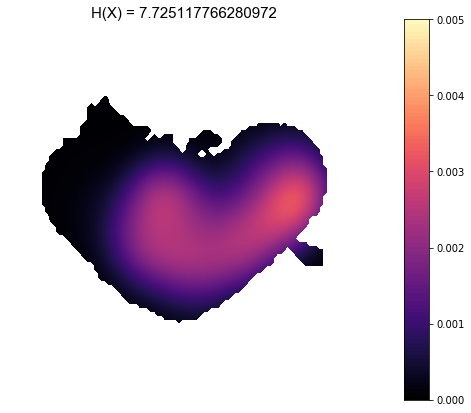

In [96]:
draw_density(dens_lineage_tracing['GFP-20d'], 
             cmap=plt.cm.magma, 
             show_axes=False, limits = (0,0.005), plot_entropy=True)

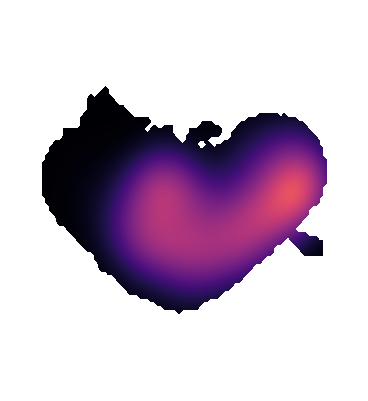

In [97]:
draw_density(dens_lineage_tracing['GFP-20d'],
             cmap=plt.cm.magma, 
             show_axes=False, limits = (0,0.005), plot_entropy=False, show_legend=False)

figname = 'UMAP_frag_density_GFP_20d.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

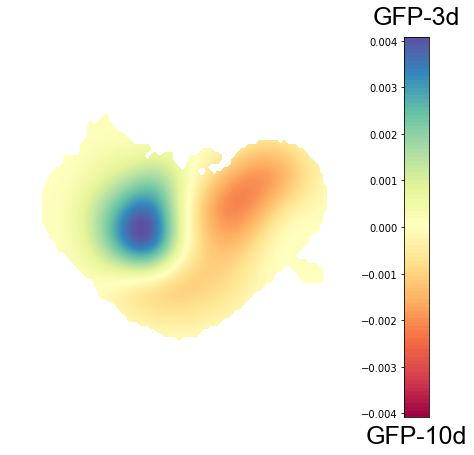

In [98]:
draw_density_vs(dens_lineage_tracing, ['GFP-3d','GFP-10d'], limits= [-0.01,0.01], text = None,  cmap = plt.cm.Spectral, pad = 2, s = 50, 
                    show_axes = False, show_legend=True)

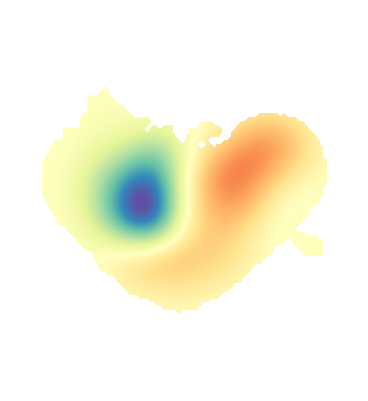

In [99]:
draw_density_vs(dens_lineage_tracing, ['GFP-3d','GFP-10d'], limits= [-0.01,0.01], text = None,  cmap = plt.cm.Spectral, pad = 2, s = 50, 
                    show_axes = False, show_legend=False)

figname = 'UMAP_frag_density_diff_10d.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

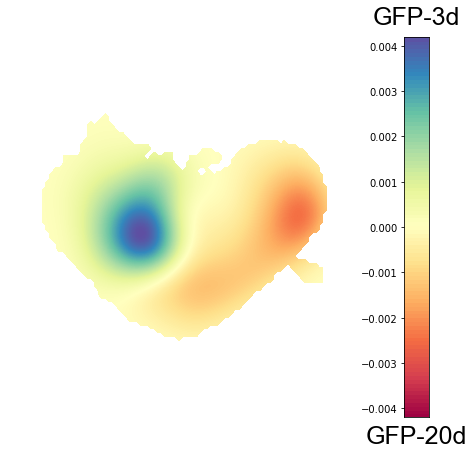

In [100]:
draw_density_vs(dens_lineage_tracing, ['GFP-3d','GFP-20d'], limits= [-0.01,0.01], text = None,  cmap = plt.cm.Spectral, pad = 2, s = 50, 
                    show_axes = False, show_legend=True)

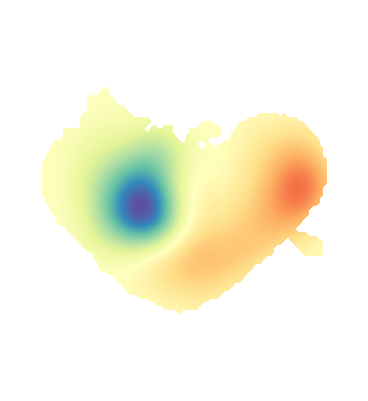

In [101]:
draw_density_vs(dens_lineage_tracing, ['GFP-3d','GFP-20d'], limits= [-0.01,0.01], text = None,  cmap = plt.cm.Spectral, pad = 2, s = 50, 
                    show_axes = False, show_legend=False)

figname = 'UMAP_frag_density_diff_20d.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Phenotypic volume

In [69]:
def sample_phenotypic_volume(dat, grps, n_it, dview, sample=1000, replace=True):
    
    ####################
    
    def get_phenotypic_volume(dat):
    
        cov = np.cov(dat)
        eigval = np.linalg.eig(cov)[0]
        phenovolume = np.sum(np.log(eigval[~np.isclose(eigval,0)]))

        return phenovolume
    
    ####################
    
    out = pd.DataFrame(index=return_unique(grps), 
                       columns=range(n_it))
    
    for g in return_unique(grps):
        c_gr = grps[grps==g].index
        
        for i in range(n_it):
            c_it = np.random.choice(c_gr, size=sample, replace=replace)
        
            out.loc[g, i] = get_phenotypic_volume(dat[c_it])
        
    return out

In [70]:
pdX = sc2pd(Xs, 'norm_log2')

In [71]:
pv_LT_time = sample_phenotypic_volume(pdX, Xs.obs['LT*time'], 100, dview, sample=50, replace=False)

[Text(0, 0, 'GFP-3d'), Text(0, 0, 'GFP-10d'), Text(0, 0, 'GFP-20d')]

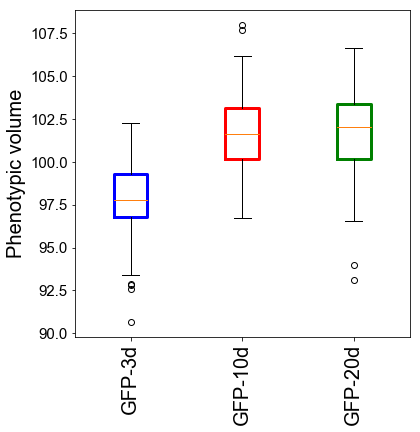

In [83]:
dat = pv_LT_time
gr_order = ['GFP-3d','GFP-10d','GFP-20d']
cmap = {'GFP-3d':'blue','GFP-10d':'red','GFP-20d':'green'}
clist = [cmap[i] for i in gr_order]

L = len(gr_order)

#initialize figure

height = 6
width = 2 * L

plt.figure(facecolor = 'w', figsize = (width, height))

#define x and y axes

ax = plt.subplot()

ax.set_xlim(-0.5, L-0.5)
ax.set_xticks(range(L))

ax.set_ylabel('Phenotypic volume', family = 'Arial', fontsize = 20)
for tick_pos, tick in enumerate(ax.yaxis.get_major_ticks()):
    ax.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
    ax.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(15)

#plot data
    
box = ax.boxplot(x=[dat.loc[i] for i in gr_order], positions = range(L))

for p,b in enumerate(box['boxes']):
            b.set_c(clist[p])
            b.set_lw(3)

ax.set_xticklabels(gr_order, family = 'Arial', fontsize = 20, rotation = 'vertical', )

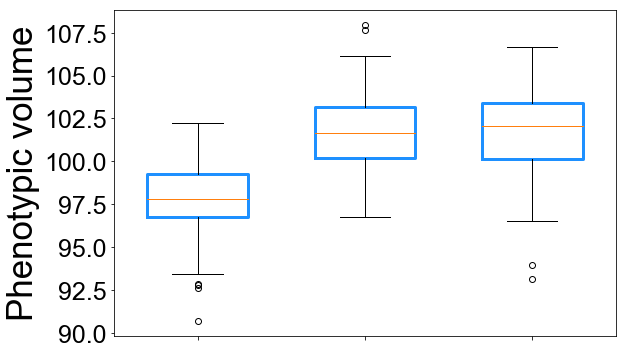

In [84]:
dat = pv_LT_time
gr_order = ['GFP-3d','GFP-10d','GFP-20d']
cmap = {'GFP-3d':'dodgerblue','GFP-10d':'dodgerblue','GFP-20d':'dodgerblue'}
clist = [cmap[i] for i in gr_order]

L = len(gr_order)

#initialize figure

height = 6
width = 3 * L

plt.figure(facecolor = 'w', figsize = (width, height))

#define x and y axes

ax = plt.subplot()

ax.set_xlim(-0.5, L-0.5)
ax.set_xticks(range(L))

ax.set_ylabel('Phenotypic volume', family = 'Arial', fontsize = 35)
for tick_pos, tick in enumerate(ax.yaxis.get_major_ticks()):
    ax.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
    ax.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(25)

#plot data
    
box = ax.boxplot(x=[dat.loc[i] for i in gr_order], positions = range(L), widths = 0.6)

for p,b in enumerate(box['boxes']):
            b.set_c(clist[p])
            b.set_lw(3)

ax.set_xticklabels([], family = 'Arial', fontsize = 20, rotation = 'vertical', )

figname = 'pv_GFP_fragment.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

/Users/simjoo/opt/anaconda3/envs/scrnaseq/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


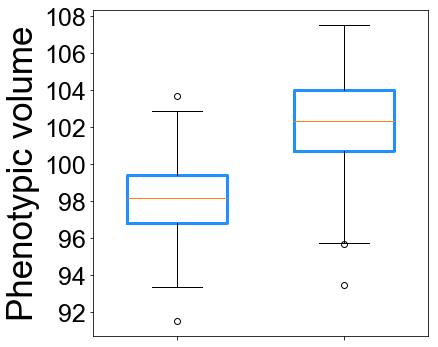

In [72]:
dat = pv_LT_time
gr_order = ['GFP-3d','GFP-10d']
cmap = {'GFP-3d':'dodgerblue','GFP-10d':'dodgerblue','GFP-20d':'dodgerblue'}
clist = [cmap[i] for i in gr_order]

L = len(gr_order)

#initialize figure

height = 6
width = 3 * L

plt.figure(facecolor = 'w', figsize = (width, height))

#define x and y axes

ax = plt.subplot()

ax.set_xlim(-0.5, L-0.5)
ax.set_xticks(range(L))

ax.set_ylabel('Phenotypic volume', family = 'Arial', fontsize = 35)
for tick_pos, tick in enumerate(ax.yaxis.get_major_ticks()):
    ax.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
    ax.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(25)

#plot data
    
box = ax.boxplot(x=[dat.loc[i] for i in gr_order], positions = range(L), widths = 0.6)

for p,b in enumerate(box['boxes']):
            b.set_c(clist[p])
            b.set_lw(3)

ax.set_xticklabels([], family = 'Arial', fontsize = 20, rotation = 'vertical', )

figname = 'pv_GFP_fragment_red.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Individual mice - GFP only

In [106]:
pv_LT_mouse = sample_phenotypic_volume(pdX, Xs.obs['LT*mouse'], 100, dview, sample=20, replace=True)

KeyboardInterrupt: 

In [ ]:
mouse_GFP_3d = list(set(Xs.obs['mouse'][Xs.obs['LT*time']=='GFP-3d']))
mouse_GFP_10d = list(set(Xs.obs['mouse'][Xs.obs['LT*time']=='GFP-10d']))
mouse_GFP_20d = list(set(Xs.obs['mouse'][Xs.obs['LT*time']=='GFP-20d']))

In [ ]:
dat = pv_LT_mouse
gr_order = mouse_GFP_3d + mouse_GFP_10d + mouse_GFP_20d
cmap = {}
for m in mouse_GFP_3d:
    cmap[m] = 'blue'
for m in mouse_GFP_10d:
    cmap[m] = 'red'
for m in mouse_GFP_20d:
    cmap[m] = 'green'
clist = [cmap[i] for i in gr_order]

L = len(gr_order)

#initialize figure

height = 6
width = 2 * L

plt.figure(facecolor = 'w', figsize = (width, height))

#define x and y axes

ax = plt.subplot()

ax.set_xlim(-0.5, L-0.5)
ax.set_xticks(range(L))

ax.set_ylabel('Phenotypic volume', family = 'Arial', fontsize = 20)
for tick_pos, tick in enumerate(ax.yaxis.get_major_ticks()):
    ax.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
    ax.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(15)

#plot data
    
box = ax.boxplot(x=[dat.loc['GFP-%s'%i] for i in gr_order], positions = range(L))

for p,b in enumerate(box['boxes']):
            b.set_c(clist[p])
            b.set_lw(3)

ax.set_xticklabels(gr_order, family = 'Arial', fontsize = 20, rotation = 'vertical', )

## Plot expression

In [109]:
pdX = sc2pd(X[Xs.obs_names], 'norm_log2')

In [111]:
Xs.obsm['X_umap_pca'][:,0] = Xs.obsm['X_umap_pca'][:,0] * -1

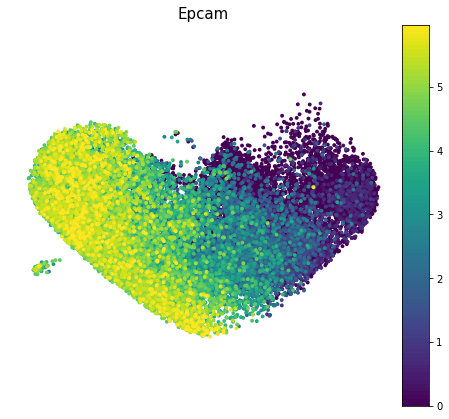

In [115]:
g = 'Epcam'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 15, show_axes=False)

figname = 'UMAP_fragment_%s.pdf' % g
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

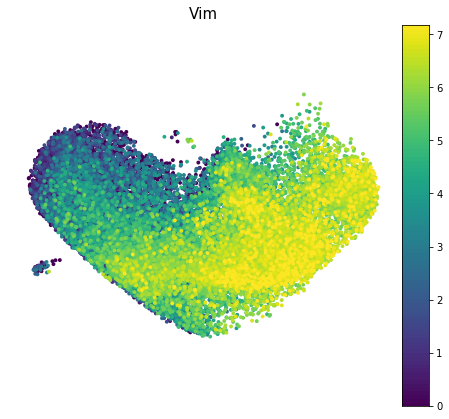

In [116]:
g = 'Vim'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = g,
                  s = 15, show_axes=False)

figname = 'UMAP_fragment_%s.pdf' % g
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

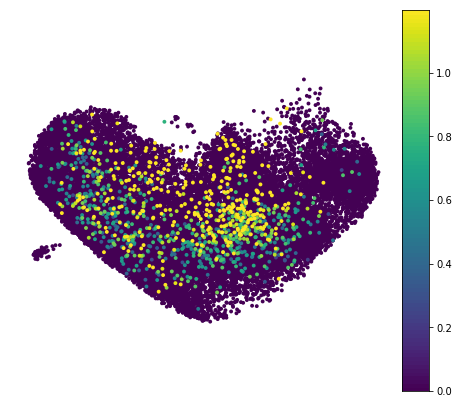

In [132]:
g = 'Lgr5'
expr = pdX.loc[g, Xs.obs_names]
draw_scatter_expr(Xs.obsm['X_umap_pca'],
                  expr,
                  np.percentile(expr, 1),
                  np.percentile(expr, 99),
                  text = '',
                  s = 15, show_axes=False)

figname = 'UMAP_fragment_%s.pdf' % g
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Plot randomly sampled cells

In [74]:
cells_GFP_3d = Xs[c_sel_3d].obs[Xs[c_sel_3d].obs['lineage_tracing']=='GFP'].index
cells_GFP_10d = Xs[c_sel_10d].obs[Xs[c_sel_10d].obs['lineage_tracing']=='GFP'].index
cells_GFP_20d = Xs[c_sel_20d].obs[Xs[c_sel_20d].obs['lineage_tracing']=='GFP'].index

In [75]:
n_sample = np.min([len(cells_GFP_3d), len(cells_GFP_10d), len(cells_GFP_20d)])

In [76]:
n_sample

167

In [63]:
sample_GFP_3d = pd.Series(0, index = c_sel_3d)
sample_GFP_3d[np.random.choice(cells_GFP_3d, n_sample, replace=False)] = 1

In [64]:
sample_GFP_10d = pd.Series(0, index = c_sel_10d)
sample_GFP_10d[np.random.choice(cells_GFP_10d, n_sample, replace=False)] = 1

In [65]:
sample_GFP_20d = pd.Series(0, index = c_sel_20d)
sample_GFP_20d[np.random.choice(cells_GFP_20d, n_sample, replace=False)] = 1

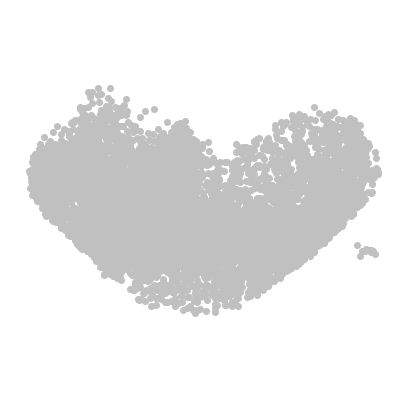

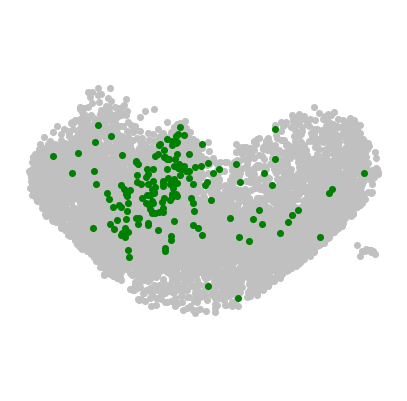

In [66]:
draw_scatter_groups_individual(Xs[c_sel_3d].obsm['X_umap_pca'], 
                    sample_GFP_3d,
                    cmap={0:'silver',1:'green'},
                    s=50, show_axes = False, show_legend=False)

figname = 'UMAP_fragment_GFP_3.pdf' 
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

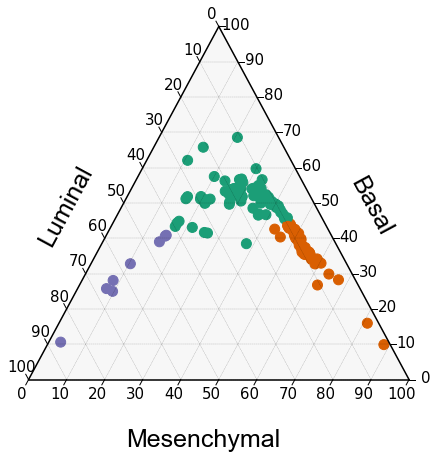

In [67]:
    c_tmp = sample_GFP_3d[sample_GFP_3d==1].index
    dat = list(zip(Xs[c_tmp].obs['pheno_prob2_pca']*100, 
                   Xs[c_tmp].obs['pheno_prob1_pca']*100,
                   Xs[c_tmp].obs['pheno_prob0_pca']*100))
    cmap = {0:'#7570b3',1:'#1b9e77',2:'#d95f02',None:'silver'}
    clist = [cmap[i] for i in Xs[c_tmp].obs['pheno_class_pca']]

    ## Boundary and Gridlines
    scale = 100
    figure, tax = ternary.figure(scale=scale)
    figure.set_figheight(7.5)
    figure.set_figwidth(7.5)

    # Draw Boundary and Gridlines
    tax.boundary(linewidth=1.5)
    tax.gridlines(color="black", multiple=10, linewidth=0.25)
    #tax.gridlines(color="black", multiple=5, linewidth=0.5)

    # Set Axis labels and Title
    fontsize = 25
    offset = 0.15
    #tax.set_title(i, fontsize=fontsize, family='Arial')
    tax.left_axis_label("Luminal", fontsize=fontsize, offset=offset, family='Arial', ha='center')
    tax.right_axis_label("Basal", fontsize=fontsize, offset=offset, family='Arial', ha='center')
    tax.bottom_axis_label("Mesenchymal", fontsize=fontsize, offset=offset, family='Arial', ha='center')

    # Set ticks
    tax.ticks(axis='lbr', linewidth=1, multiple=10, offset=0.015, fontsize=15)

    # Background color
    tax.set_background_color(color="whitesmoke", alpha=0.7) # the detault, essentially

    # Remove default Matplotlib Axes
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')

    #plot scatter

    tax.scatter(dat, s=100, color = clist)
    
    figname = 'ternary_sc_fragment_GFP_3d.pdf'
    plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)
    

In [86]:
Set(Xs.obs['LT*time'][c_tmp])

NameError: name 'Set' is not defined

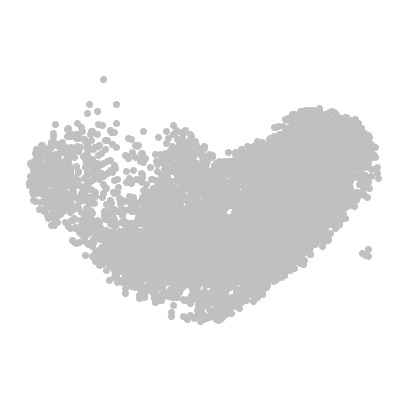

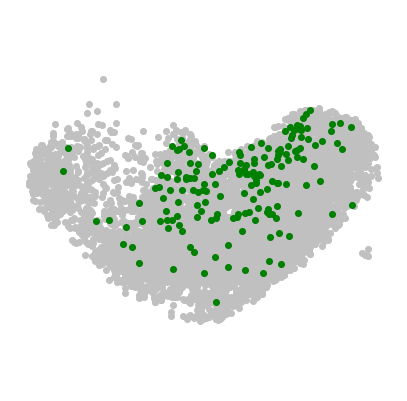

In [68]:
draw_scatter_groups_individual(Xs[c_sel_10d].obsm['X_umap_pca'], 
                    sample_GFP_10d,
                    cmap={0:'silver',1:'green'},
                    s=50, show_axes = False, show_legend=False)

figname = 'UMAP_fragment_GFP_10.pdf' 
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

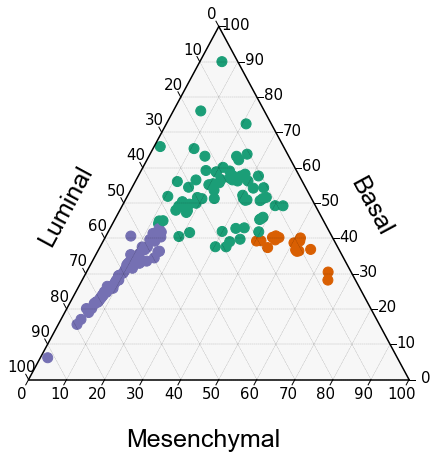

In [69]:
    c_tmp = sample_GFP_10d[sample_GFP_10d==1].index
    dat = list(zip(Xs[c_tmp].obs['pheno_prob2_pca']*100, 
                   Xs[c_tmp].obs['pheno_prob1_pca']*100,
                   Xs[c_tmp].obs['pheno_prob0_pca']*100))
    cmap = {0:'#7570b3',1:'#1b9e77',2:'#d95f02',None:'silver'}
    clist = [cmap[i] for i in Xs[c_tmp].obs['pheno_class_pca']]

    ## Boundary and Gridlines
    scale = 100
    figure, tax = ternary.figure(scale=scale)
    figure.set_figheight(7.5)
    figure.set_figwidth(7.5)

    # Draw Boundary and Gridlines
    tax.boundary(linewidth=1.5)
    tax.gridlines(color="black", multiple=10, linewidth=0.25)
    #tax.gridlines(color="black", multiple=5, linewidth=0.5)

    # Set Axis labels and Title
    fontsize = 25
    offset = 0.15
    #tax.set_title(i, fontsize=fontsize, family='Arial')
    tax.left_axis_label("Luminal", fontsize=fontsize, offset=offset, family='Arial', ha='center')
    tax.right_axis_label("Basal", fontsize=fontsize, offset=offset, family='Arial', ha='center')
    tax.bottom_axis_label("Mesenchymal", fontsize=fontsize, offset=offset, family='Arial', ha='center')

    # Set ticks
    tax.ticks(axis='lbr', linewidth=1, multiple=10, offset=0.015, fontsize=15)

    # Background color
    tax.set_background_color(color="whitesmoke", alpha=0.7) # the detault, essentially

    # Remove default Matplotlib Axes
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')

    #plot scatter

    tax.scatter(dat, s=100, color = clist)
    
    figname = 'ternary_sc_fragment_GFP_10d.pdf'
    plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

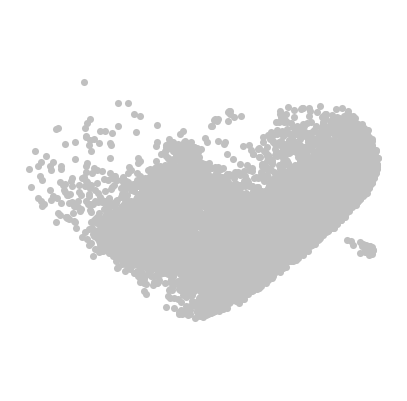

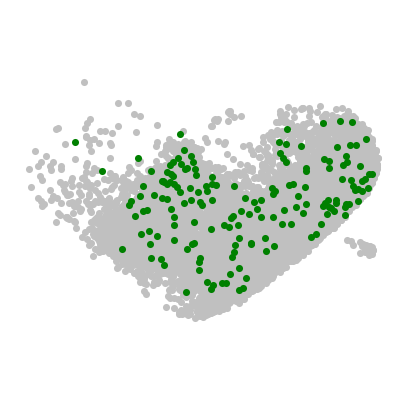

In [70]:
draw_scatter_groups_individual(Xs[c_sel_20d].obsm['X_umap_pca'], 
                    sample_GFP_20d,
                    cmap={0:'silver',1:'green'},
                    s=50, show_axes = False, show_legend=False)

figname = 'UMAP_fragment_GFP_20.pdf' 
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

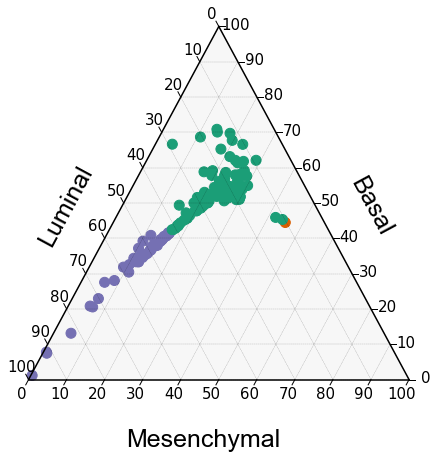

In [71]:
    c_tmp = sample_GFP_20d[sample_GFP_20d==1].index
    dat = list(zip(Xs[c_tmp].obs['pheno_prob2_pca']*100, 
                   Xs[c_tmp].obs['pheno_prob1_pca']*100,
                   Xs[c_tmp].obs['pheno_prob0_pca']*100))
    cmap = {0:'#7570b3',1:'#1b9e77',2:'#d95f02',None:'silver'}
    clist = [cmap[i] for i in Xs[c_tmp].obs['pheno_class_pca']]

    ## Boundary and Gridlines
    scale = 100
    figure, tax = ternary.figure(scale=scale)
    figure.set_figheight(7.5)
    figure.set_figwidth(7.5)

    # Draw Boundary and Gridlines
    tax.boundary(linewidth=1.5)
    tax.gridlines(color="black", multiple=10, linewidth=0.25)
    #tax.gridlines(color="black", multiple=5, linewidth=0.5)

    # Set Axis labels and Title
    fontsize = 25
    offset = 0.15
    #tax.set_title(i, fontsize=fontsize, family='Arial')
    tax.left_axis_label("Luminal", fontsize=fontsize, offset=offset, family='Arial', ha='center')
    tax.right_axis_label("Basal", fontsize=fontsize, offset=offset, family='Arial', ha='center')
    tax.bottom_axis_label("Mesenchymal", fontsize=fontsize, offset=offset, family='Arial', ha='center')

    # Set ticks
    tax.ticks(axis='lbr', linewidth=1, multiple=10, offset=0.015, fontsize=15)

    # Background color
    tax.set_background_color(color="whitesmoke", alpha=0.7) # the detault, essentially

    # Remove default Matplotlib Axes
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')

    #plot scatter

    tax.scatter(dat, s=100, color = clist)
    
    figname = 'ternary_sc_fragment_GFP_20d.pdf'
    plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

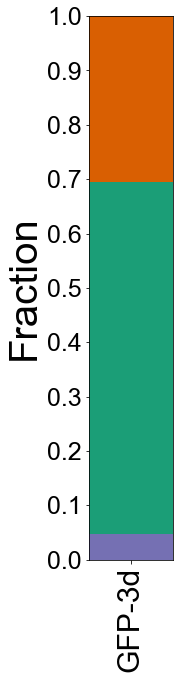

In [95]:
c_tmp = sample_GFP_3d[sample_GFP_3d==1].index
draw_fraction_cluster(Xs.obs['LT*time'][c_tmp], 
                      Xs.obs['pheno_class_pca'][c_tmp], 
                      {0:'#7570b3',1:'#1b9e77',2:'#d95f02'},
                      #cl_order = c_sel,
                      var_order=[0,1,2])

figname = 'fraction_fragment_GFP_3d.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

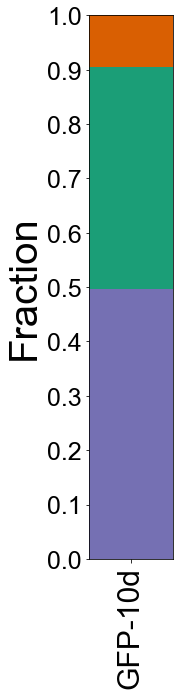

In [96]:
c_tmp = sample_GFP_10d[sample_GFP_10d==1].index
draw_fraction_cluster(Xs.obs['LT*time'][c_tmp], 
                      Xs.obs['pheno_class_pca'][c_tmp], 
                      {0:'#7570b3',1:'#1b9e77',2:'#d95f02'},
                      #cl_order = c_sel,
                      var_order=[0,1,2])

figname = 'fraction_fragment_GFP_10d.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

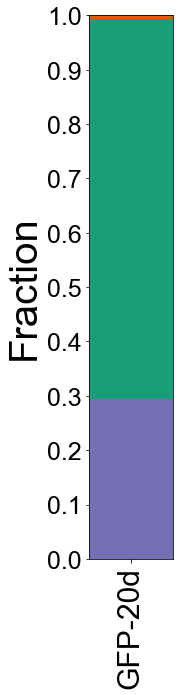

In [97]:
c_tmp = sample_GFP_20d[sample_GFP_20d==1].index
draw_fraction_cluster(Xs.obs['LT*time'][c_tmp], 
                      Xs.obs['pheno_class_pca'][c_tmp], 
                      {0:'#7570b3',1:'#1b9e77',2:'#d95f02'},
                      #cl_order = c_sel,
                      var_order=[0,1,2])

figname = 'fraction_fragment_GFP_20d.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

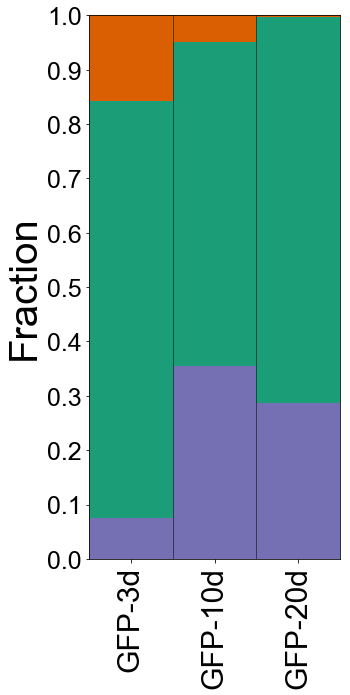

In [94]:
c_sel = Xs.obs['LT*time'][Xs.obs['LT*time'].isin(['GFP-3d','GFP-10d','GFP-20d'])].index
draw_fraction_cluster(Xs.obs['LT*time'][c_sel], 
                      Xs.obs['pheno_class_pca'][c_sel], 
                      {0:'#7570b3',1:'#1b9e77',2:'#d95f02'},
                      cl_order = ['GFP-3d','GFP-10d','GFP-20d'],
                      var_order=[0,1,2])

## Compositional entropy

In [77]:
comp_tumor_GFP = pd.DataFrame(index=['3d','10d','20d'], columns = ['0','1','2','ent'])

for p,i in enumerate([cells_GFP_3d, cells_GFP_10d, cells_GFP_20d]):
    l=len(i)
    cnt_tmp = Counter(Xs.obs['pheno_class_pca'][i])
    comp_tumor_GFP.iloc[p][0:3] = np.array([cnt_tmp[0], cnt_tmp[1], cnt_tmp[2]])/l
    comp_tumor_GFP['ent'].iloc[p] = scipy.stats.entropy(list(comp_tumor_GFP[['0','1','2']].iloc[p]))

In [78]:
it = 100
n = 50
ent_GFP_rs = pd.DataFrame(index = ['3d','10d','20d'], columns = range(it))

for p,q in enumerate([cells_GFP_3d, cells_GFP_10d, cells_GFP_20d]):
    for i in range(it):
        c_tmp = np.random.choice(q,n,replace=False)
        cnt_tmp = Counter(Xs.obs['pheno_class_pca'][c_tmp])
        ent_GFP_rs.iloc[p][i] = scipy.stats.entropy(np.array([cnt_tmp[0], cnt_tmp[1], cnt_tmp[2]])/n)

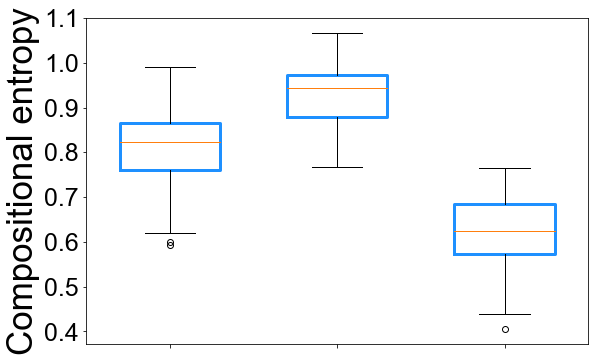

In [79]:
dat = ent_GFP_rs
gr_order = ['3d','10d','20d']
cmap = {'3d':'dodgerblue','10d':'dodgerblue','20d':'dodgerblue'}
clist = [cmap[i] for i in gr_order]

L = len(gr_order)

#initialize figure

height = 6
width = 3 * L

plt.figure(facecolor = 'w', figsize = (width, height))

#define x and y axes

ax = plt.subplot()

ax.set_xlim(-0.5, L-0.5)
ax.set_xticks(range(L))

ax.set_ylabel('Compositional entropy', family = 'Arial', fontsize = 35)
for tick_pos, tick in enumerate(ax.yaxis.get_major_ticks()):
    ax.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
    ax.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(25)

#plot data
    
#plot data
    
box = ax.boxplot(x=[dat.loc[i] for i in gr_order], positions = range(L), widths = 0.6)

for p,b in enumerate(box['boxes']):
            b.set_c(clist[p])
            b.set_lw(3)

ax.set_xticklabels([], family = 'Arial', fontsize = 20, rotation = 'vertical', )

figname = 'ent_GFP_fragment.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

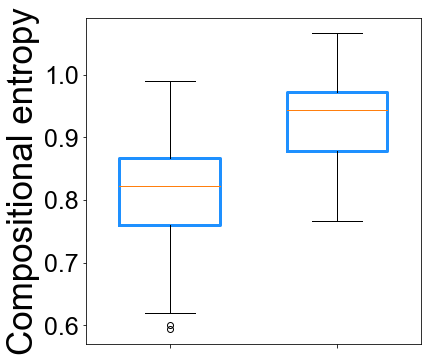

In [81]:
dat = ent_GFP_rs
gr_order = ['3d','10d']
cmap = {'3d':'dodgerblue','10d':'dodgerblue','20d':'dodgerblue'}
clist = [cmap[i] for i in gr_order]

L = len(gr_order)

#initialize figure

height = 6
width = 3 * L

plt.figure(facecolor = 'w', figsize = (width, height))

#define x and y axes

ax = plt.subplot()

ax.set_xlim(-0.5, L-0.5)
ax.set_xticks(range(L))

ax.set_ylabel('Compositional entropy', family = 'Arial', fontsize = 35)
for tick_pos, tick in enumerate(ax.yaxis.get_major_ticks()):
    ax.yaxis.get_major_ticks()[tick_pos].label.set_family('Arial')
    ax.yaxis.get_major_ticks()[tick_pos].label.set_fontsize(25)

#plot data
    
#plot data
    
box = ax.boxplot(x=[dat.loc[i] for i in gr_order], positions = range(L), widths = 0.6)

for p,b in enumerate(box['boxes']):
            b.set_c(clist[p])
            b.set_lw(3)

ax.set_xticklabels([], family = 'Arial', fontsize = 20, rotation = 'vertical', )

figname = 'ent_GFP_fragment_red.pdf'
plt.savefig('%s/%s' % (path_figures, figname), 
            format = 'pdf', 
            transparent = True, 
            bbox_inches = 'tight', 
            pad_inches = 0, 
            rasterized = True)

## Pseudotime position

In [82]:
def draw_violin_pseudotime(adata, dpt_var, group_var, cmap=plt.cm.tab20, gr_order=None, scatter=False, bw='scott'):
    
    assert dpt_var in adata.obs.columns, 'dpt_var not in adata'
    dpt = adata.obs[dpt_var]
    
    assert group_var in adata.obs.columns, 'group_var not in adata'
    groups = adata.obs[group_var]
    
    L = len(set(groups))
    
    if not gr_order:
        gr_order = return_unique(groups)
    
    #initialize figure

    height = 1 * L
    width = 10

    plt.figure(facecolor = 'w', figsize = (width, height))
    
    #define colormap
    
    if type(cmap) != dict:
        cm = cmap
        cmap = {}
        for ix, gr in enumerate(return_unique(groups)):
            cmap[gr] = cm(float(ix) / 20)
            
    clist = [cmap[groups[c]] for c in groups.index]
    
    #define x and y axes

    ax = plt.subplot()
    
    ax.set_xlim(0,1)
    ax.set_xticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    ax.set_xticklabels([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], family = 'Arial', fontsize = 20, rotation = 'vertical')
    ax.set_xlabel('Pseudotime', family = 'Arial', fontsize = 30)
    
    ax.set_ylim(L-0.5,-0.5)
    ax.set_yticks(range(0,L))
    ax.set_yticklabels(gr_order, family = 'Arial', fontsize = 20)

    
    #plot data

    for p, i in enumerate(gr_order):

        i_tmp = groups[groups==i].index
        d_tmp = dpt[i_tmp].values
        
        if scatter:
            ax.scatter(d_tmp,
                       [p-(i-0.5)/2 for i in np.random.rand(len(d_tmp), 1)],
                        color = 'k',
                        s = 5,
                        alpha = 0.25,
                        zorder = 1)

        violin = ax.violinplot([d_tmp],
                                positions = [p],
                                vert=False,
                                showextrema=False,
                                widths=0.95, 
                               bw_method=bw)

        for v in violin['bodies']:
            v.set_facecolor(cmap[i])
            v.set_linewidth(0)
            v.set_alpha(0.75)
            v.set_zorder(0)

        ax.axhline(p, color='k', linewidth=2)

In [76]:
c_sel = list(cells_GFP_3d) + list(cells_GFP_10d) + list(cells_GFP_20d)

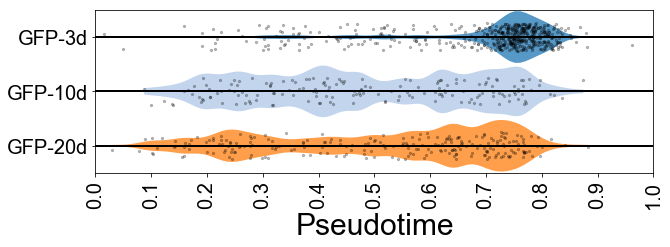

In [83]:
draw_violin_pseudotime(Xs[c_sel], 'dpt_pseudotime_pca', 'LT*time', gr_order=None, bw=0.1, scatter=True)